# GDP Models


In [1]:
library(UsingR)
library(quantmod)
library(ggplot2)
library(grid)
library(gridExtra)
library(knitr)
library(kableExtra)
library(tools)
library(zoo)
library(signal)
library(stringr)
library(corrplot)
library(caret)
library(rpart)
library(rpart.plot)
library(randomForest)
library(Quandl)
library(nnet)
library(readr)
#library(devtools)
#install_github("andrewuhl/RollingWindow")
library(RollingWindow)
#install.packages("EIAdata")
library(EIAdata)
library(gtable)
library(data.table)
library(readxl)
library(plotly)

Loading required package: MASS

Loading required package: HistData

Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: 'Hmisc'


The following objects are masked from 'package:base':

    format.pval, units



Attaching package: 'UsingR'


The following object is masked from 'package:survival':

    cancer


Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Version 0.4-0 included new data defaults. See ?getSymbols.


Attaching package: 'quantmod'


The following object is masked from 'package:Hmisc':

    Lag



Attaching package: 'signal'


The following objects are masked from 'package:stats'

Call helper functions

In [2]:
source("plotHelper.r")

Define the source of the data (local or web) and whether to update the models.

In [3]:
b.refresh.models = FALSE

Define the plotting ranges and vertical defaults

In [4]:
dt.recent = as.Date("2017-01-01")
d.GSPC.max = 3500

Load up the off-line data

In [5]:
load("C:/Users/Rainy/OneDrive//RecessionIndicator_Buffer.RData")

This snippet is needed because some of the ticker symbols include are invalid variable names so re-cast those variable names.

In [6]:
df.symbols$string.symbol <-
  str_replace_all(df.symbols$string.symbol, "[^[:alnum:]]", "")

Do the interpolation to daily samples and tidy the data

In [7]:
source("calcInterpolate.r")

In [8]:
df.data <- calcInterpolate(df.data, df.symbols)

Warning message in merge.xts(xtsData, get(df.symbols$string.symbol[idx])):
"NAs introduced by coercion"


Truncate the data. A very few data series do go back to 1854, but most don't even go past WWII so truncate the dataframe

In [9]:
df.data <- df.data[as.Date(rownames(df.data)) > as.Date("1940-01-01"),]

Create aggreagate data series
Some analysis requires that two or more series be combined. For example, normallizing debt by GDP to get a sense of the proportion of debt to the total economy helps understand the debt cycle.

In [10]:
source("calcAggregateSeries.r")

Calculate the year-over-year, 50 day moving average, and other features in the data

In [11]:
source("calcFeatures.r")

In [12]:
lst.df <- calcFeatures(df.data, df.symbols)
df.data <- lst.df[[1]]
df.symbols <- lst.df[[2]]

[1] "USREC has zero or negative values. Log series will be zero."
[1] "GSFTX.Volume has zero or negative values. Log series will be zero."
[1] "LFMIX.Volume has zero or negative values. Log series will be zero."
[1] "LFMCX.Volume has zero or negative values. Log series will be zero."
[1] "LFMAX.Volume has zero or negative values. Log series will be zero."
[1] "LCSIX.Volume has zero or negative values. Log series will be zero."
[1] "VBIRX.Volume has zero or negative values. Log series will be zero."
[1] "VFSUX.Volume has zero or negative values. Log series will be zero."
[1] "LTUIX.Volume has zero or negative values. Log series will be zero."
[1] "PTTPX.Volume has zero or negative values. Log series will be zero."
[1] "NERYX.Volume has zero or negative values. Log series will be zero."
[1] "STIGX.Volume has zero or negative values. Log series will be zero."
[1] "HLGAX.Volume has zero or negative values. Log series will be zero."
[1] "FTRGX.Volume has zero or negative values. Log series 

These are auxilliary series that use the YoY and smoothed data.

In [13]:
source("calcFeaturesAggregate.r")

Build the recession data frame

In [14]:
source("calcRecession.r")

## GDP Models

### Regression, Retail sales

See if we can get there with a simple regression model. Begin by taking a look at how these datapoints correlate


In [15]:
# Exclude the Covid19 datasets
dt.start.prediction <- as.Date(max(c(index(CLF16OV[1]), index(POPTHM[1]))))
dt.end.prediction <- as.Date("2020-01-31")

Correlation for the entire data set

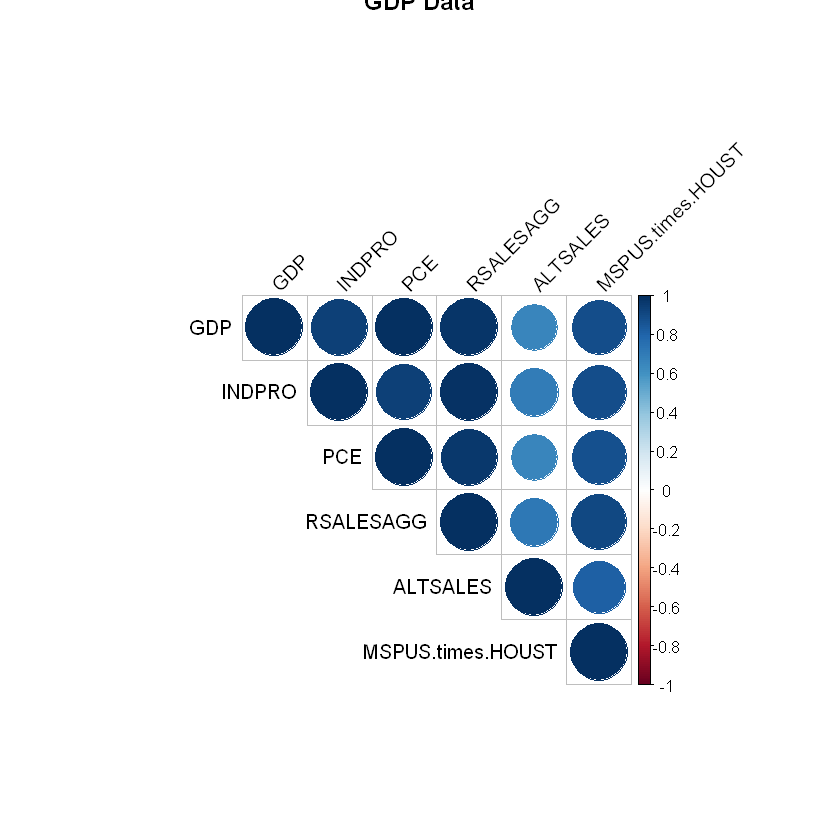

In [16]:
training.cor <-
  df.data[, c("GDP", "INDPRO", "PCE", "RSALESAGG", "ALTSALES", "MSPUS.times.HOUST")]

  rcorr.data <- rcorr(as.matrix(training.cor), type = "pearson")
  #print(rcorr.data)

  corrplot::corrplot(cor(training.cor), type="upper", order="original", 
           tl.col="black", tl.srt=45, title ="GDP Data")

Begin training up some models

In [17]:
df.gdp.model <-
  df.data[df.data$date >= dt.start.prediction &
            df.data$date <= dt.end.prediction,]

# I break the data into three sets: 50% for training, 25% for testing, and 25% for validation.
set.seed(123456)
in.train <- createDataPartition(y=df.gdp.model$GDP, p = 0.50, list=FALSE)
df.train <- df.gdp.model[in.train,]
df.data.rest <- df.gdp.model[-in.train,]
in.val <- createDataPartition(y = df.data.rest$GDP, p = 0.50, list = FALSE)
df.val <- df.data.rest[in.val,]
df.test <- df.data.rest[-in.val,]
rm(df.data.rest)

# Perform the linear fit
list.fit.reg <- train(
  GDP ~ INDPRO + PCE + RSALESAGG + ALTSALES + MSPUS.times.HOUST,
  data = df.train,
  method = "lm",
  preProcess = c('center', 'scale')
)


# Perform the pca fit
list.fit.pcr <- train(
  GDP ~ INDPRO + PCE + RSALESAGG + ALTSALES,
  data = df.train,
  method = "pcr",
  preProcess = c('center', 'scale')
)


This section adds the linear prediction to the data frame

In [18]:
# Add linear prediction to the dataframe
str.symbol <- "GDP.lm"
df.data[str.symbol] <-
  predict(list.fit.reg, newdata = df.data)

# Add the linear model prediction to the symbols table
str.description <- "Linear Model Prediction\nGDP given INDPRO,\nPCE, RSALESAGG, auto sales,\nand housing"
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol,
      string.source = "Predict",
      string.description = str.description,
      string.label.y = getPlotYLabel(df.symbols, "POPTHM")[1],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )


Add the linear prediction year-over-year growth

In [19]:
#The YoY calculation
str.symbolYoY <- paste(str.symbol, "_YoY", sep = "")
df.data[str.symbolYoY] <- CalcYoY(df.data, str.symbol, 365)

df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbolYoY,
      string.source = "Calc",
      string.description = paste(str.description, "\nYear over Year", sep =
                                   ""),
      string.label.y = "Percent",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

Add linear prediction by PCA to the dataframe

In [20]:
str.symbol.pcr <- "GDP.pcr"
df.data[str.symbol.pcr] <-
  predict(list.fit.pcr, newdata = df.data)

# Add the linear model prediction to the symbols table
str.description.pcr <- "PCA regression\nGDP given INDPRO,\nPCE, and RSALESAGG, and auto sales"  
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol.pcr,
      string.source = "Predict",
      string.description = str.description.pcr,
      string.label.y = getPlotYLabel(df.symbols, "POPTHM")[1],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

Add the PCA prediction year-over-year growth

In [21]:
#The YoY calculation
str.symbolYoY <- paste(str.symbol.pcr, "_YoY", sep = "")
df.data[str.symbolYoY] <- CalcYoY(df.data, str.symbol.pcr, 365)

df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbolYoY,
      string.source = "Calc",
      string.description = paste(str.description.pcr, "\nYear over Year", sep =
                                   ""),
      string.label.y = "Percent",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

Plot the predicted and actual values

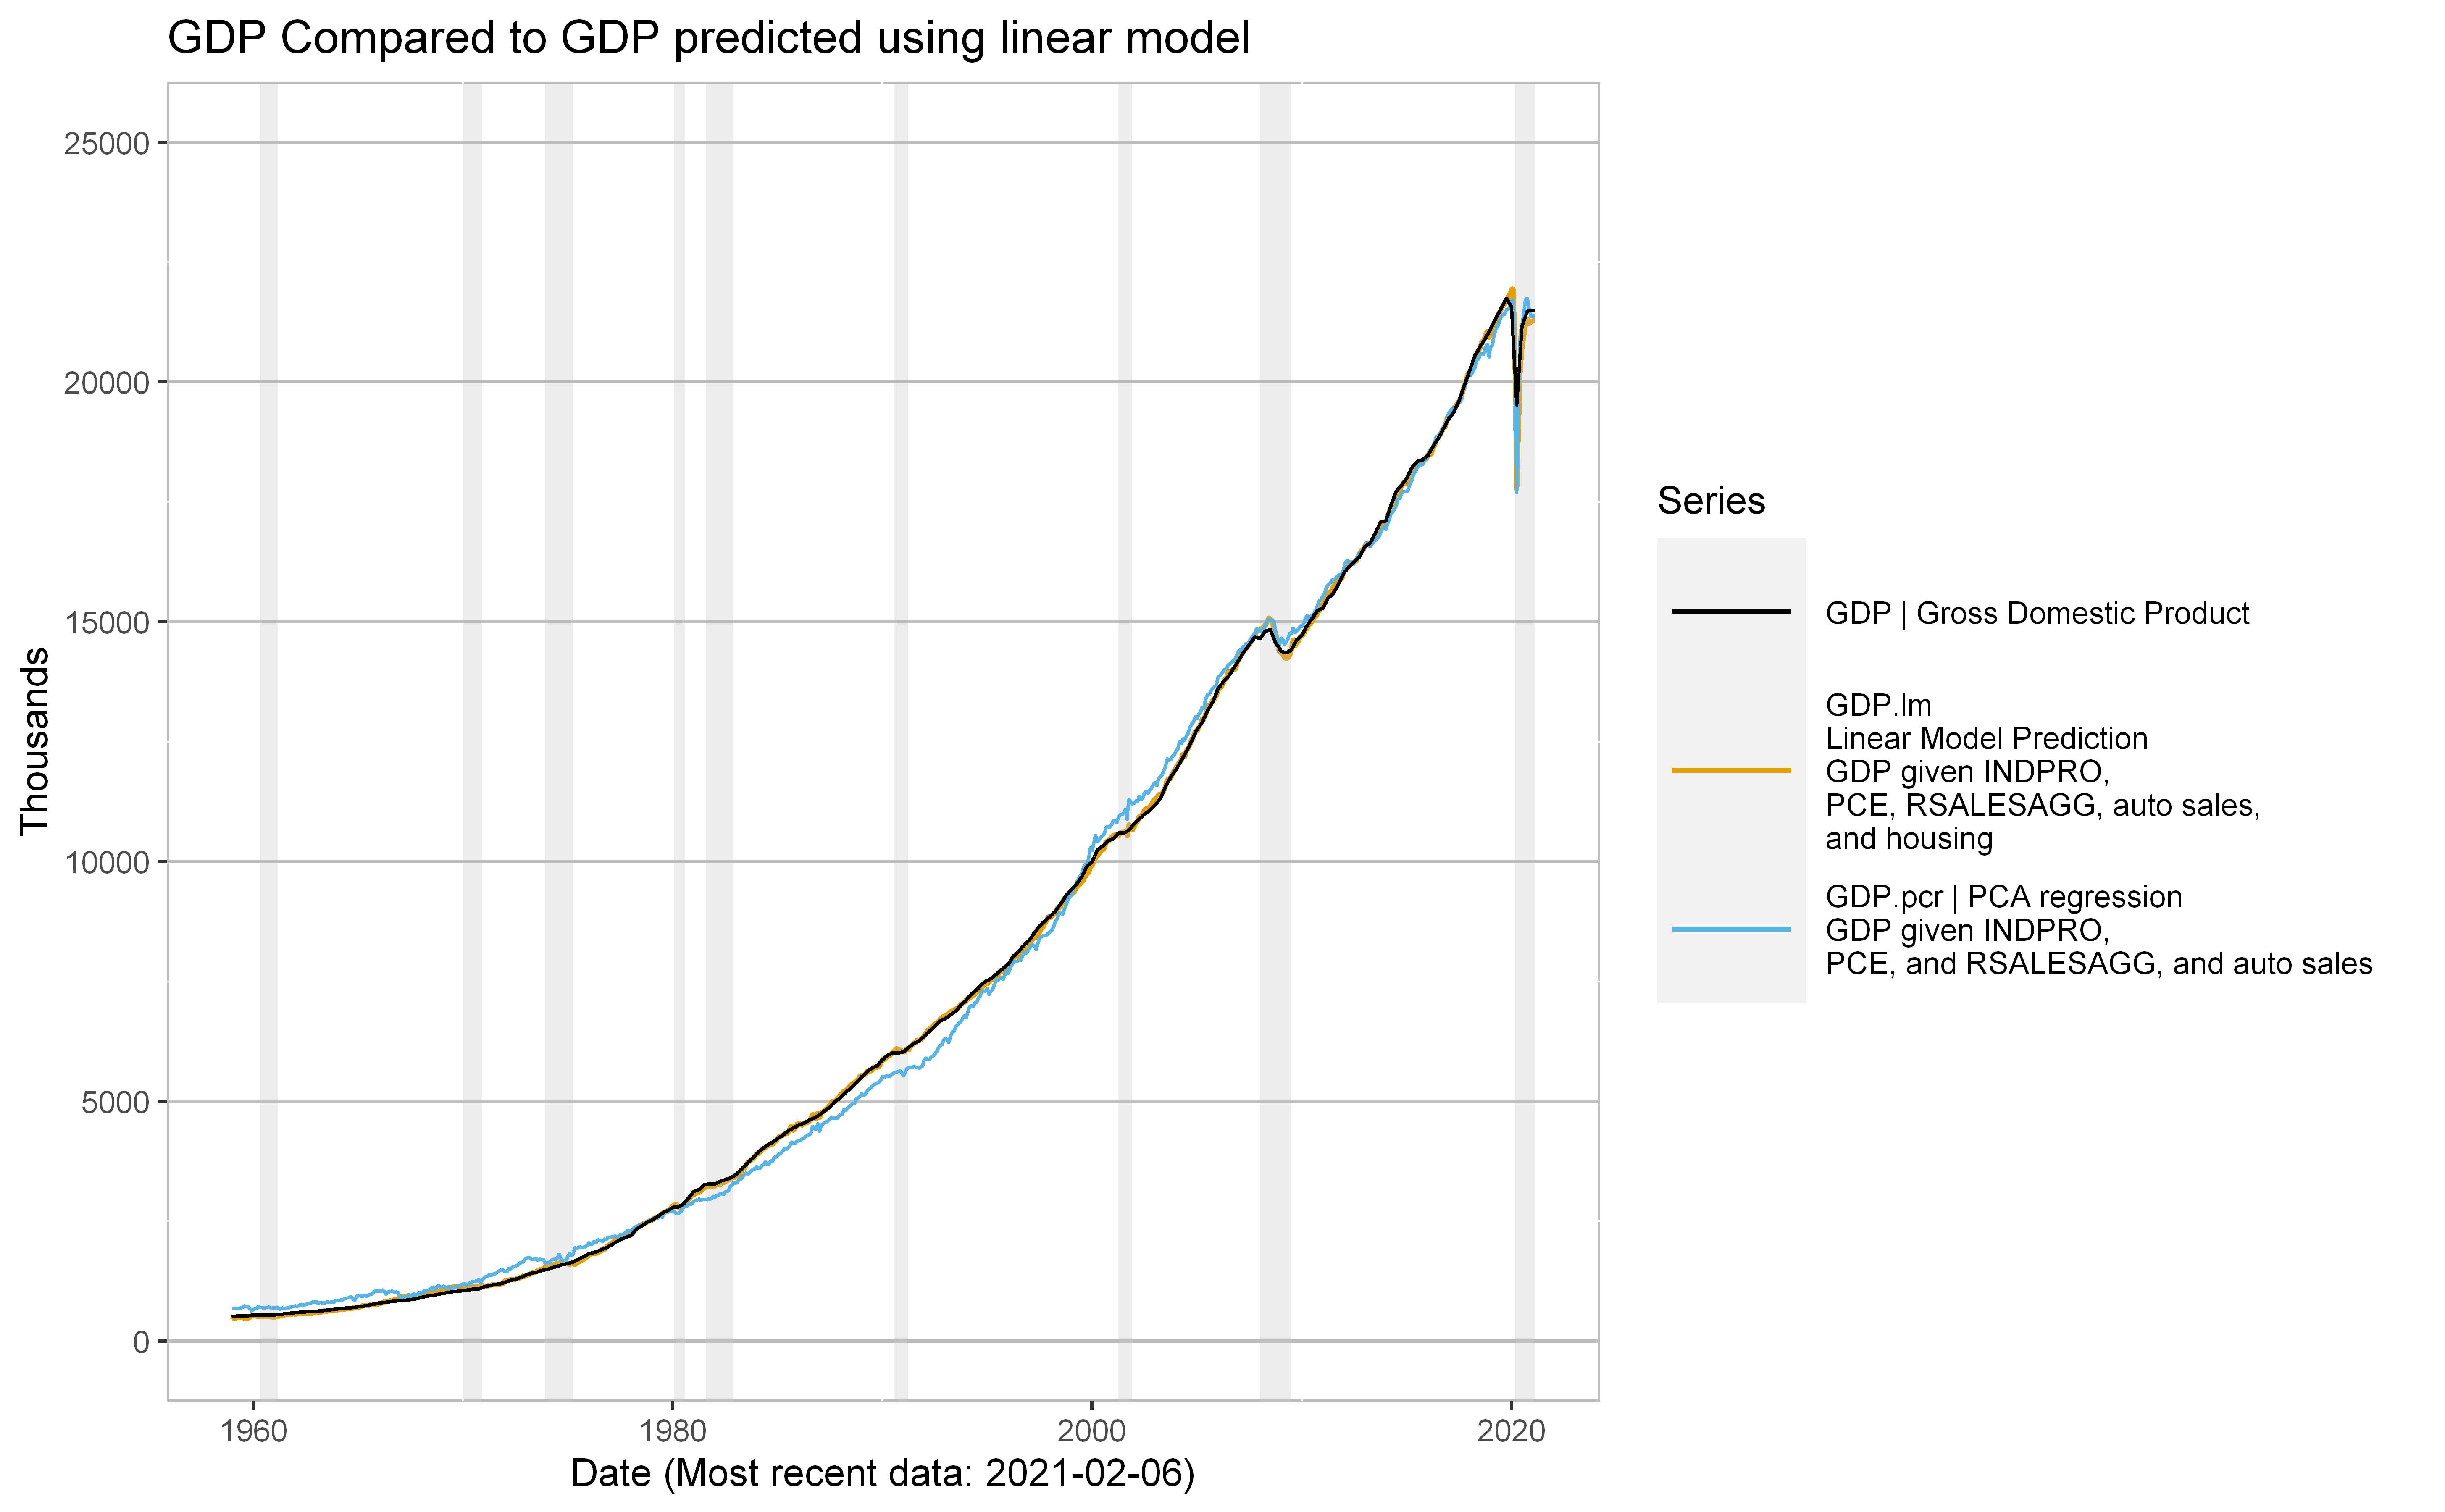

In [22]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
datay <- "GDP.lm"
datay.aux <- "GDP.pcr"
datay.aux.1 <- "GDP"
ylim <- c(0, 25000)
dt.end <- Sys.Date()
myPlot <- 
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "GDP Compared to GDP predicted using linear model",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.start.prediction, dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux))
  ),
  na.rm = TRUE
)
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux.1,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux.1))
  ),
  na.rm = TRUE
)

print(myPlot)

Looking at some more recent data points

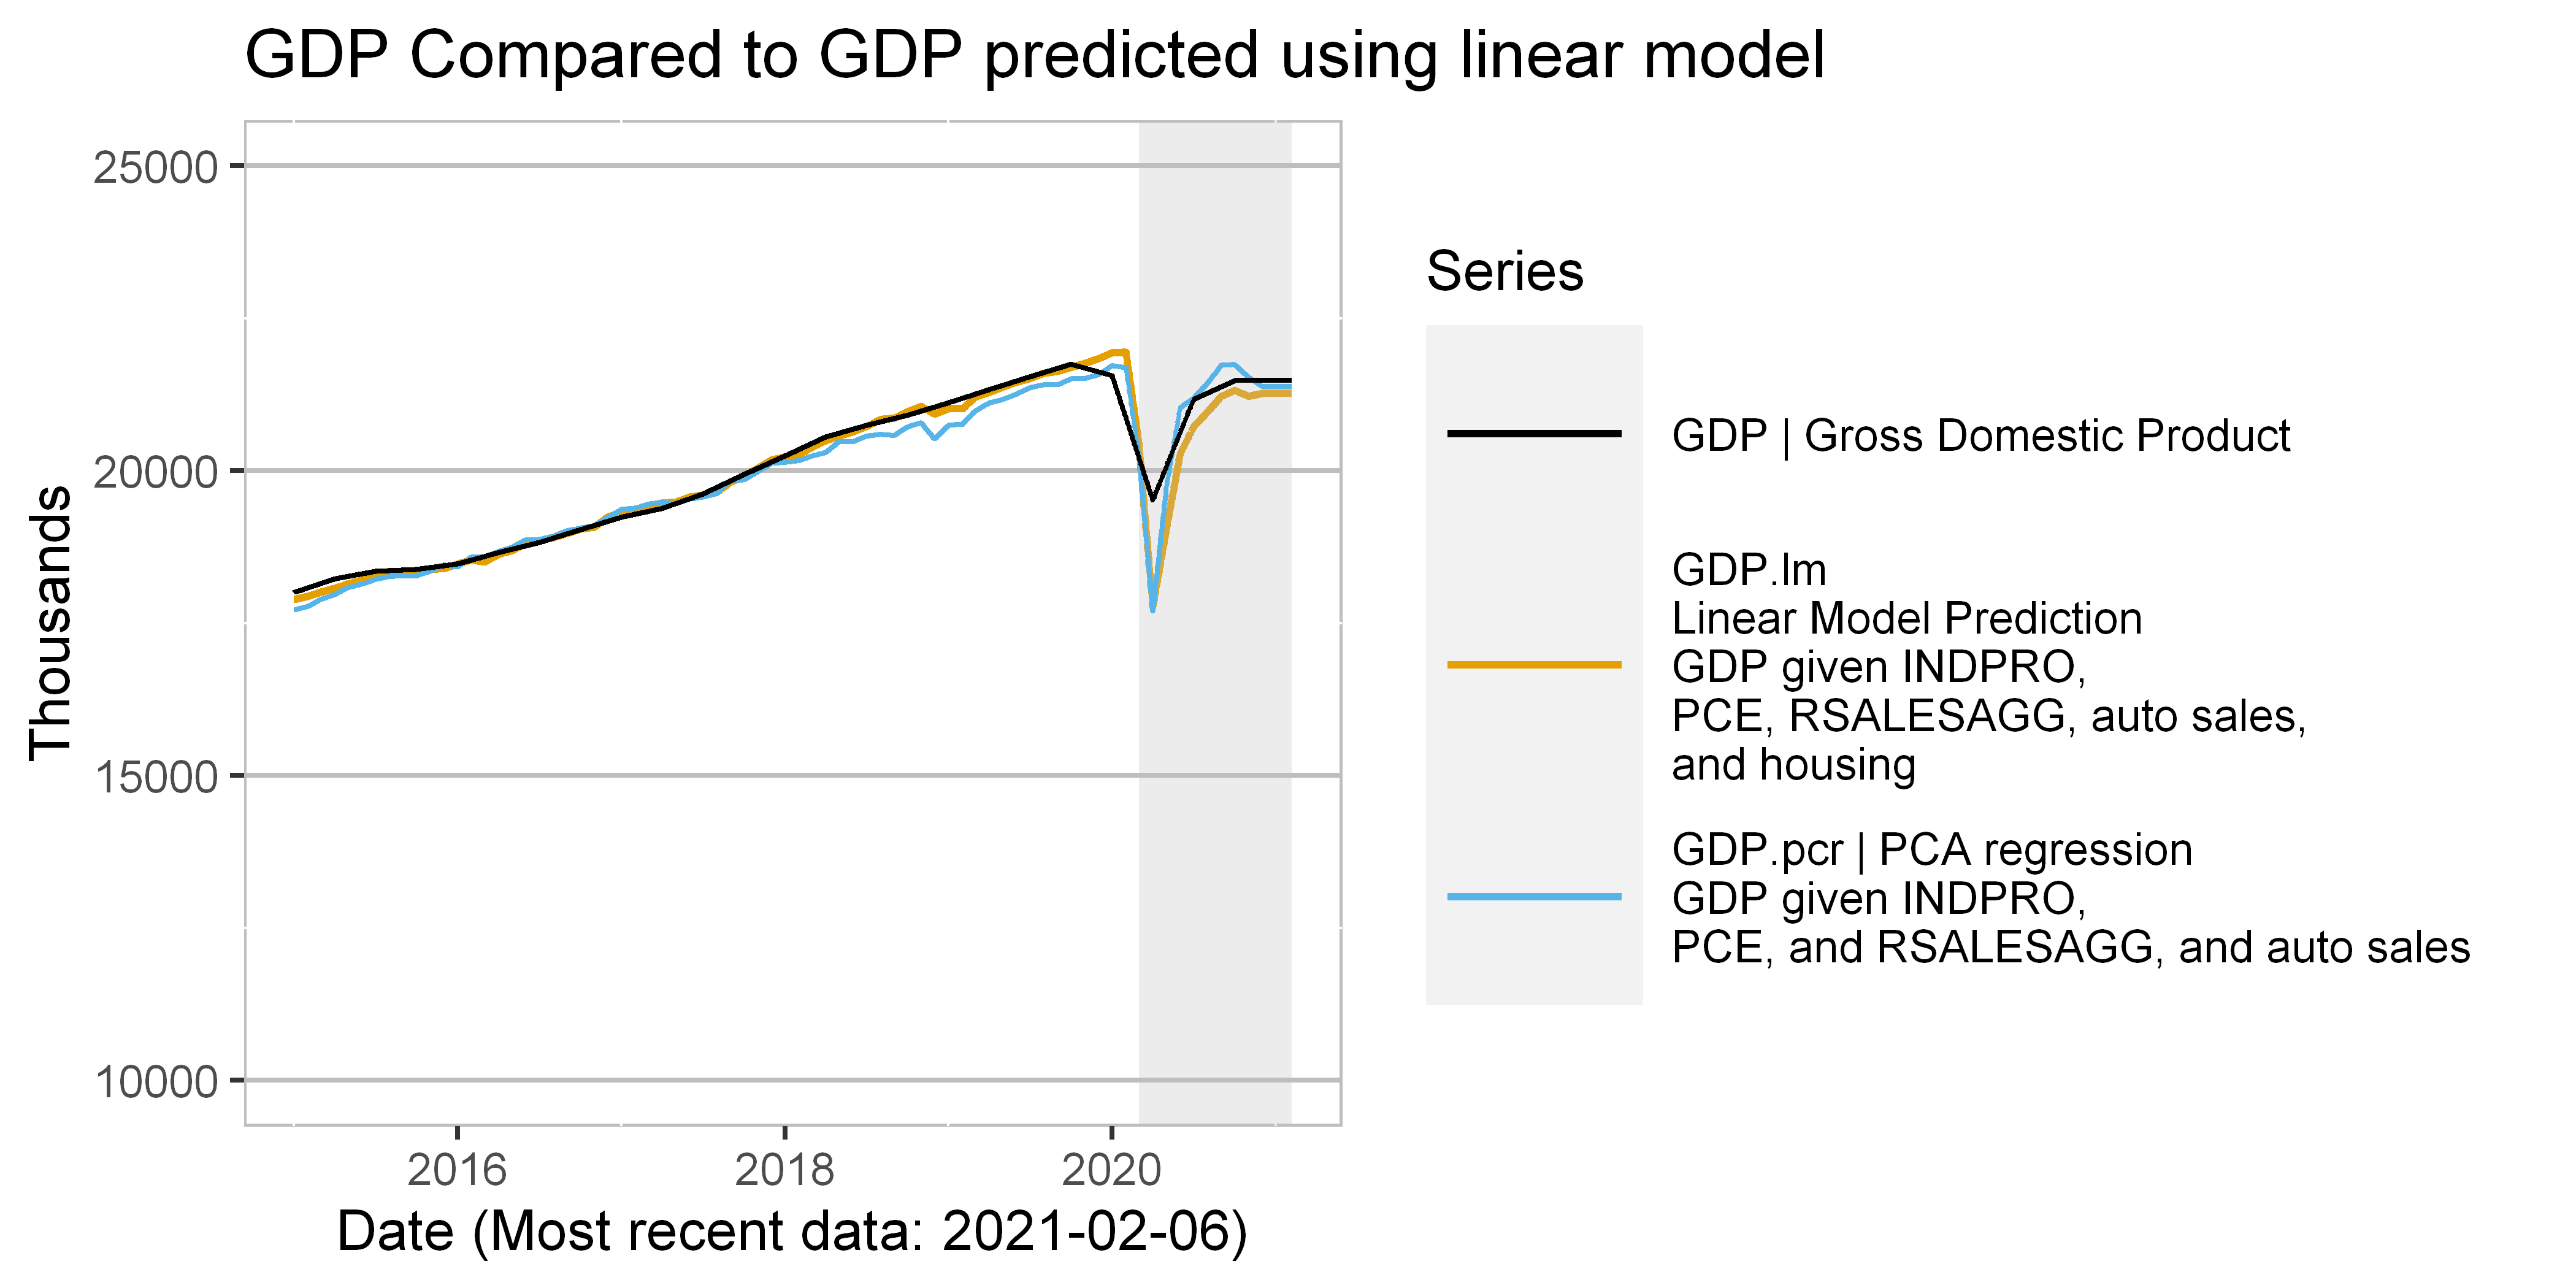

In [23]:
options(repr.plot.width = 7, repr.plot.height = 3.5, repr.plot.res = 600)
datay <- "GDP.lm"
datay.aux <- "GDP.pcr"
datay.aux.1 <- "GDP"
ylim <- c(10000, 25000)
dt.end <- Sys.Date()
dt.start <- as.Date("2015-01-01")
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "GDP Compared to GDP predicted using linear model",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.start, dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux))
  ),
  na.rm = TRUE
)
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux.1,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux.1))
  ),
  na.rm = TRUE
)

print(myPlot)

In [24]:
df.data$GDPNOW <- df.data$GDPNOW/4 

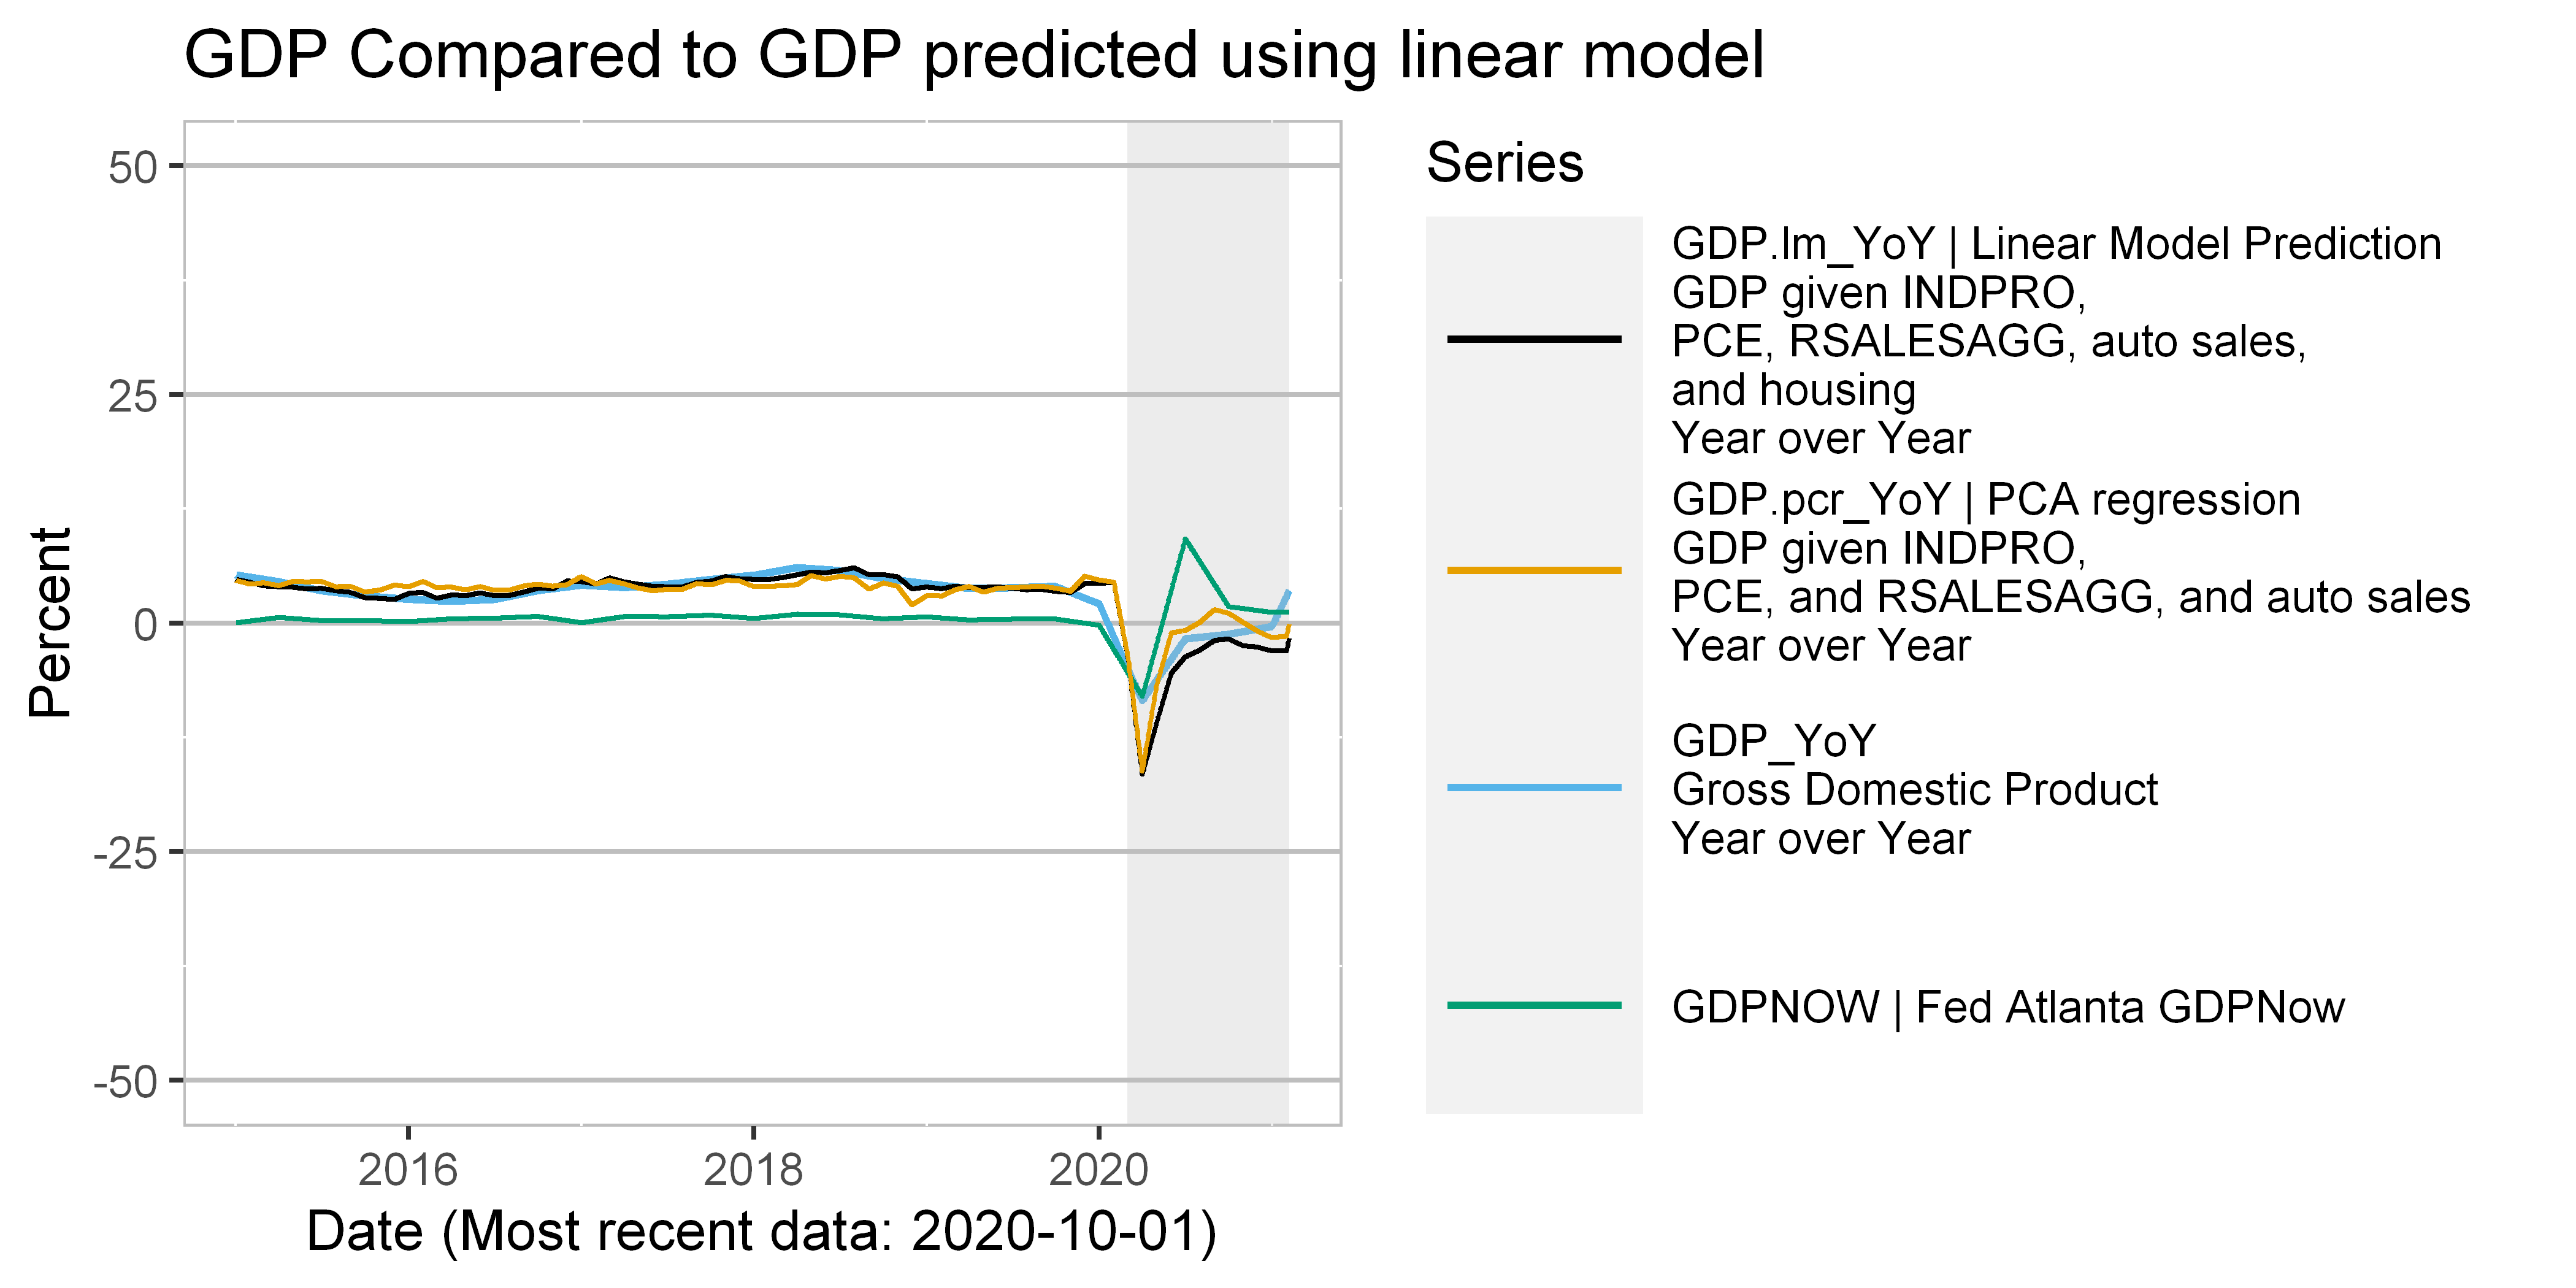

In [25]:
datay <- "GDP_YoY"
datay.aux <- "GDP.lm_YoY"
datay.aux.2 <- "GDP.pcr_YoY"
datay.aux.1 <- "GDPNOW"
ylim <- c(-50, 50)
dt.end <- Sys.Date()
dt.start <- as.Date("2015-01-01")
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "GDP Compared to GDP predicted using linear model",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.start, dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux))
  ),
  na.rm = TRUE
)
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux.1,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux.1))
  ),
  na.rm = TRUE
)

myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux.2,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux.2))
  ),
  na.rm = TRUE
)

print(myPlot)

Look at how the GDP linear fit performed on the test data partition

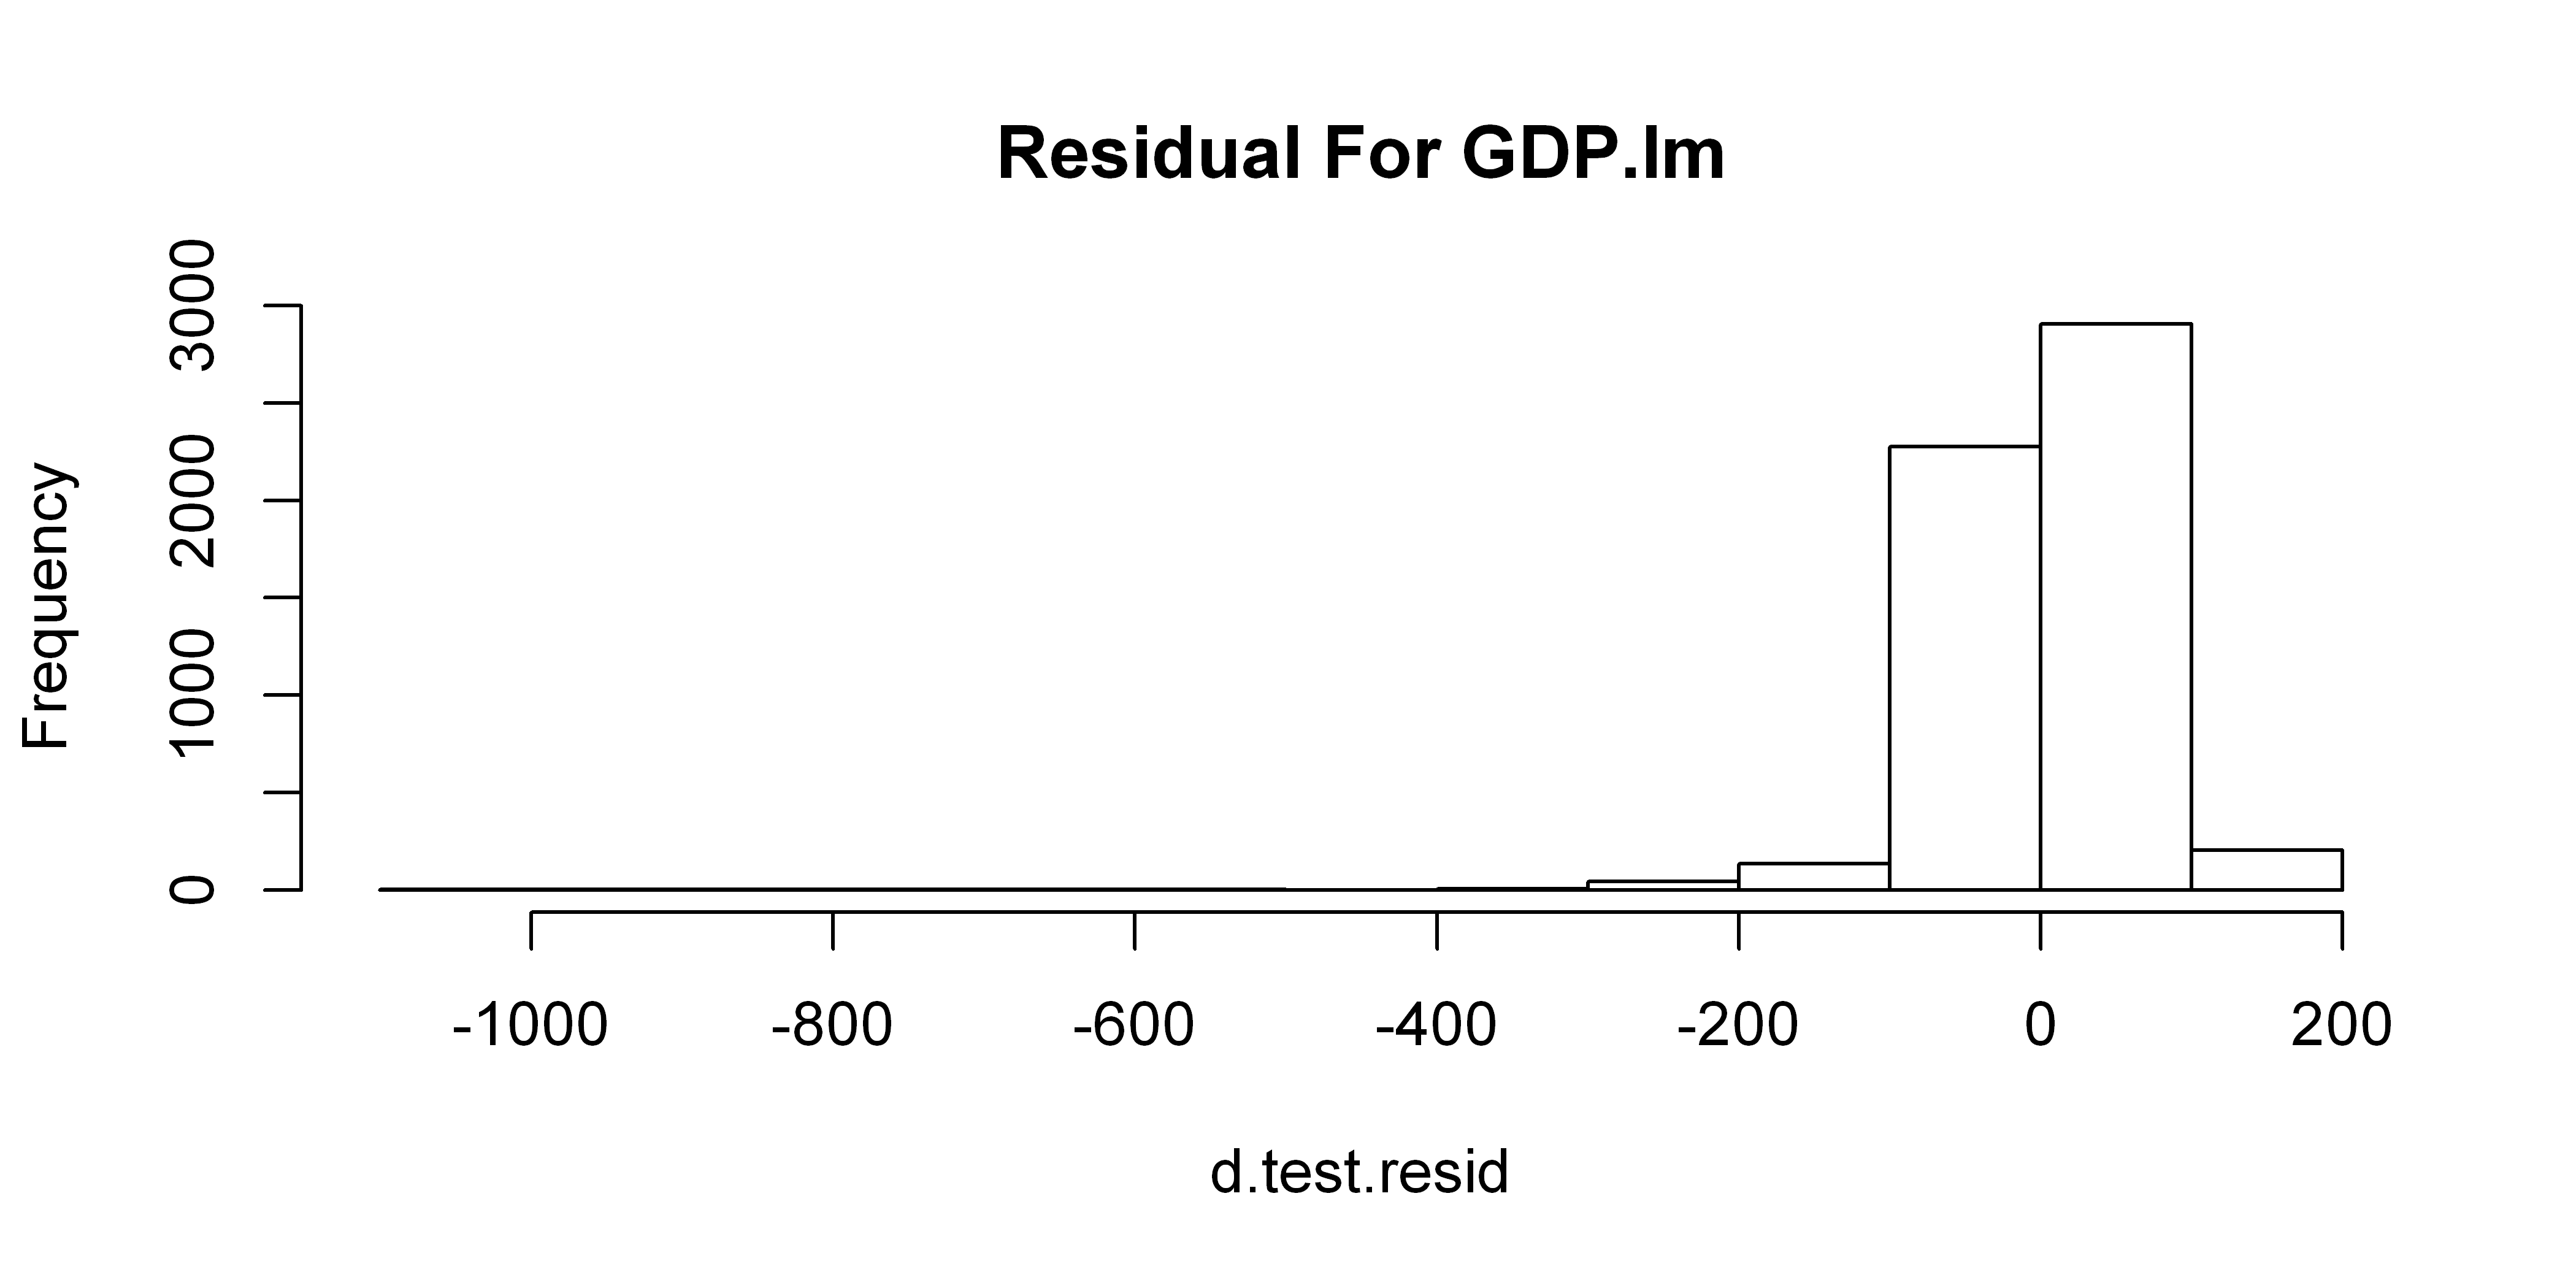

In [26]:
d.test.resid = (df.test$GDP - predict(list.fit.reg, newdata = df.test))
hist(d.test.resid, main=paste("Residual For", str.symbol, sep=" "))
sd.fit.gdp.m = sd(d.test.resid)

In [27]:
list.fit.reg$finalModel


Call:
lm(formula = .outcome ~ ., data = dat)

Coefficients:
      (Intercept)             INDPRO                PCE          RSALESAGG  
          7402.49             693.22            6264.35            -688.75  
         ALTSALES  MSPUS.times.HOUST  
            33.64              38.20  


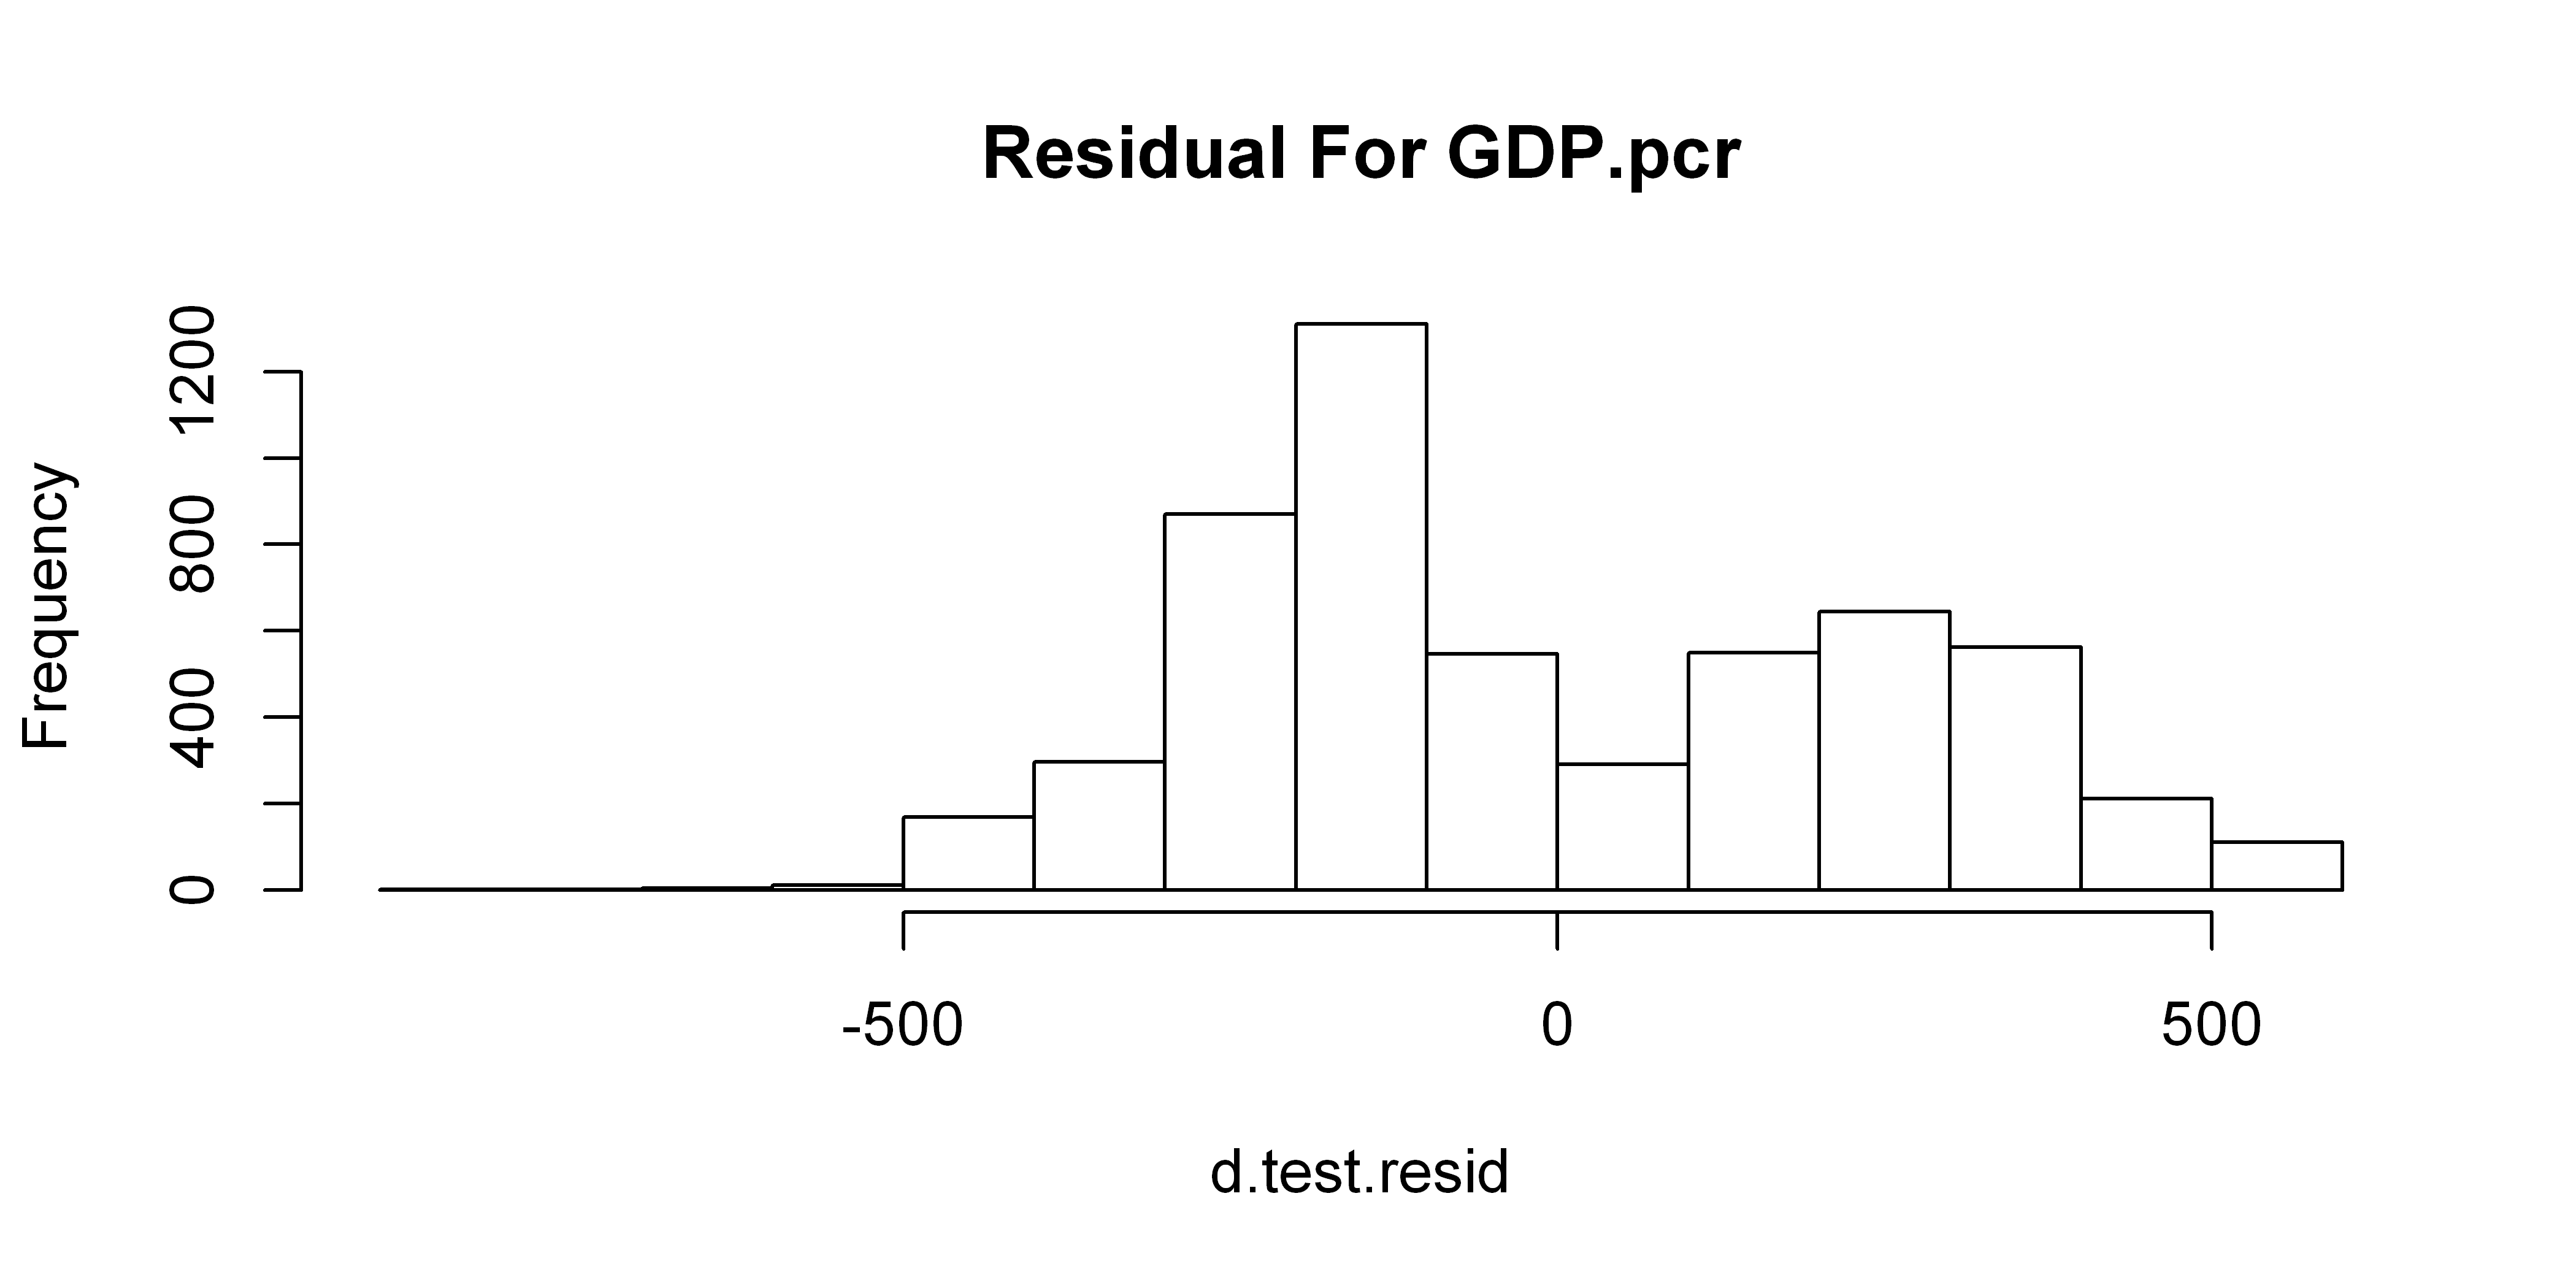

In [28]:
d.test.resid = (df.test$GDP - predict(list.fit.pcr, newdata = df.test))
hist(d.test.resid, main=paste("Residual For", str.symbol.pcr, sep=" "))
sd.fit.gdp.pcr = sd(d.test.resid)

In [29]:
summary(list.fit.pcr)

Data: 	X dimension: 11156 4 
	Y dimension: 11156 1
Fit method: svdpc
Number of components considered: 3
TRAINING: % variance explained
          1 comps  2 comps  3 comps
X           86.40    98.64    99.80
.outcome    92.76    97.75    99.84


Document the residual as well

In [30]:
str.symbol.res <- "GDP.lm.res"
df.data[str.symbol.res] <- df.data$GDP - df.data[str.symbol]

# Add the GDP linear model prediction residual to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol.res,
      string.source = "Predict Resid.",
      string.description = "Residual for \nGDP given INDPRO,PCE, RSALESAGG,\nauto sales, and home sales",
      string.label.y = df.symbols[df.symbols$string.symbol==str.symbol,"string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )


Document the PCR residual

In [31]:
str.symbol.pcr.res <- "GDP.pcr.res"
df.data[str.symbol.pcr.res] <- df.data$GDP - df.data[str.symbol.pcr]

# Add the GDP linear model prediction residual to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol.pcr.res,
      string.source = "Predict Resid.",
      string.description = "PCR Residual for \nGDP given INDPRO,\nPCE, and RSALESAGG",
      string.label.y = df.symbols[df.symbols$string.symbol==str.symbol,"string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )


Plot the residual  GDP to the linear fit prediction. 

The residuals decrease quite a bit during the Covid numbers, at least as of Jun 2020. Probably indicates uncertainty in the numbers.

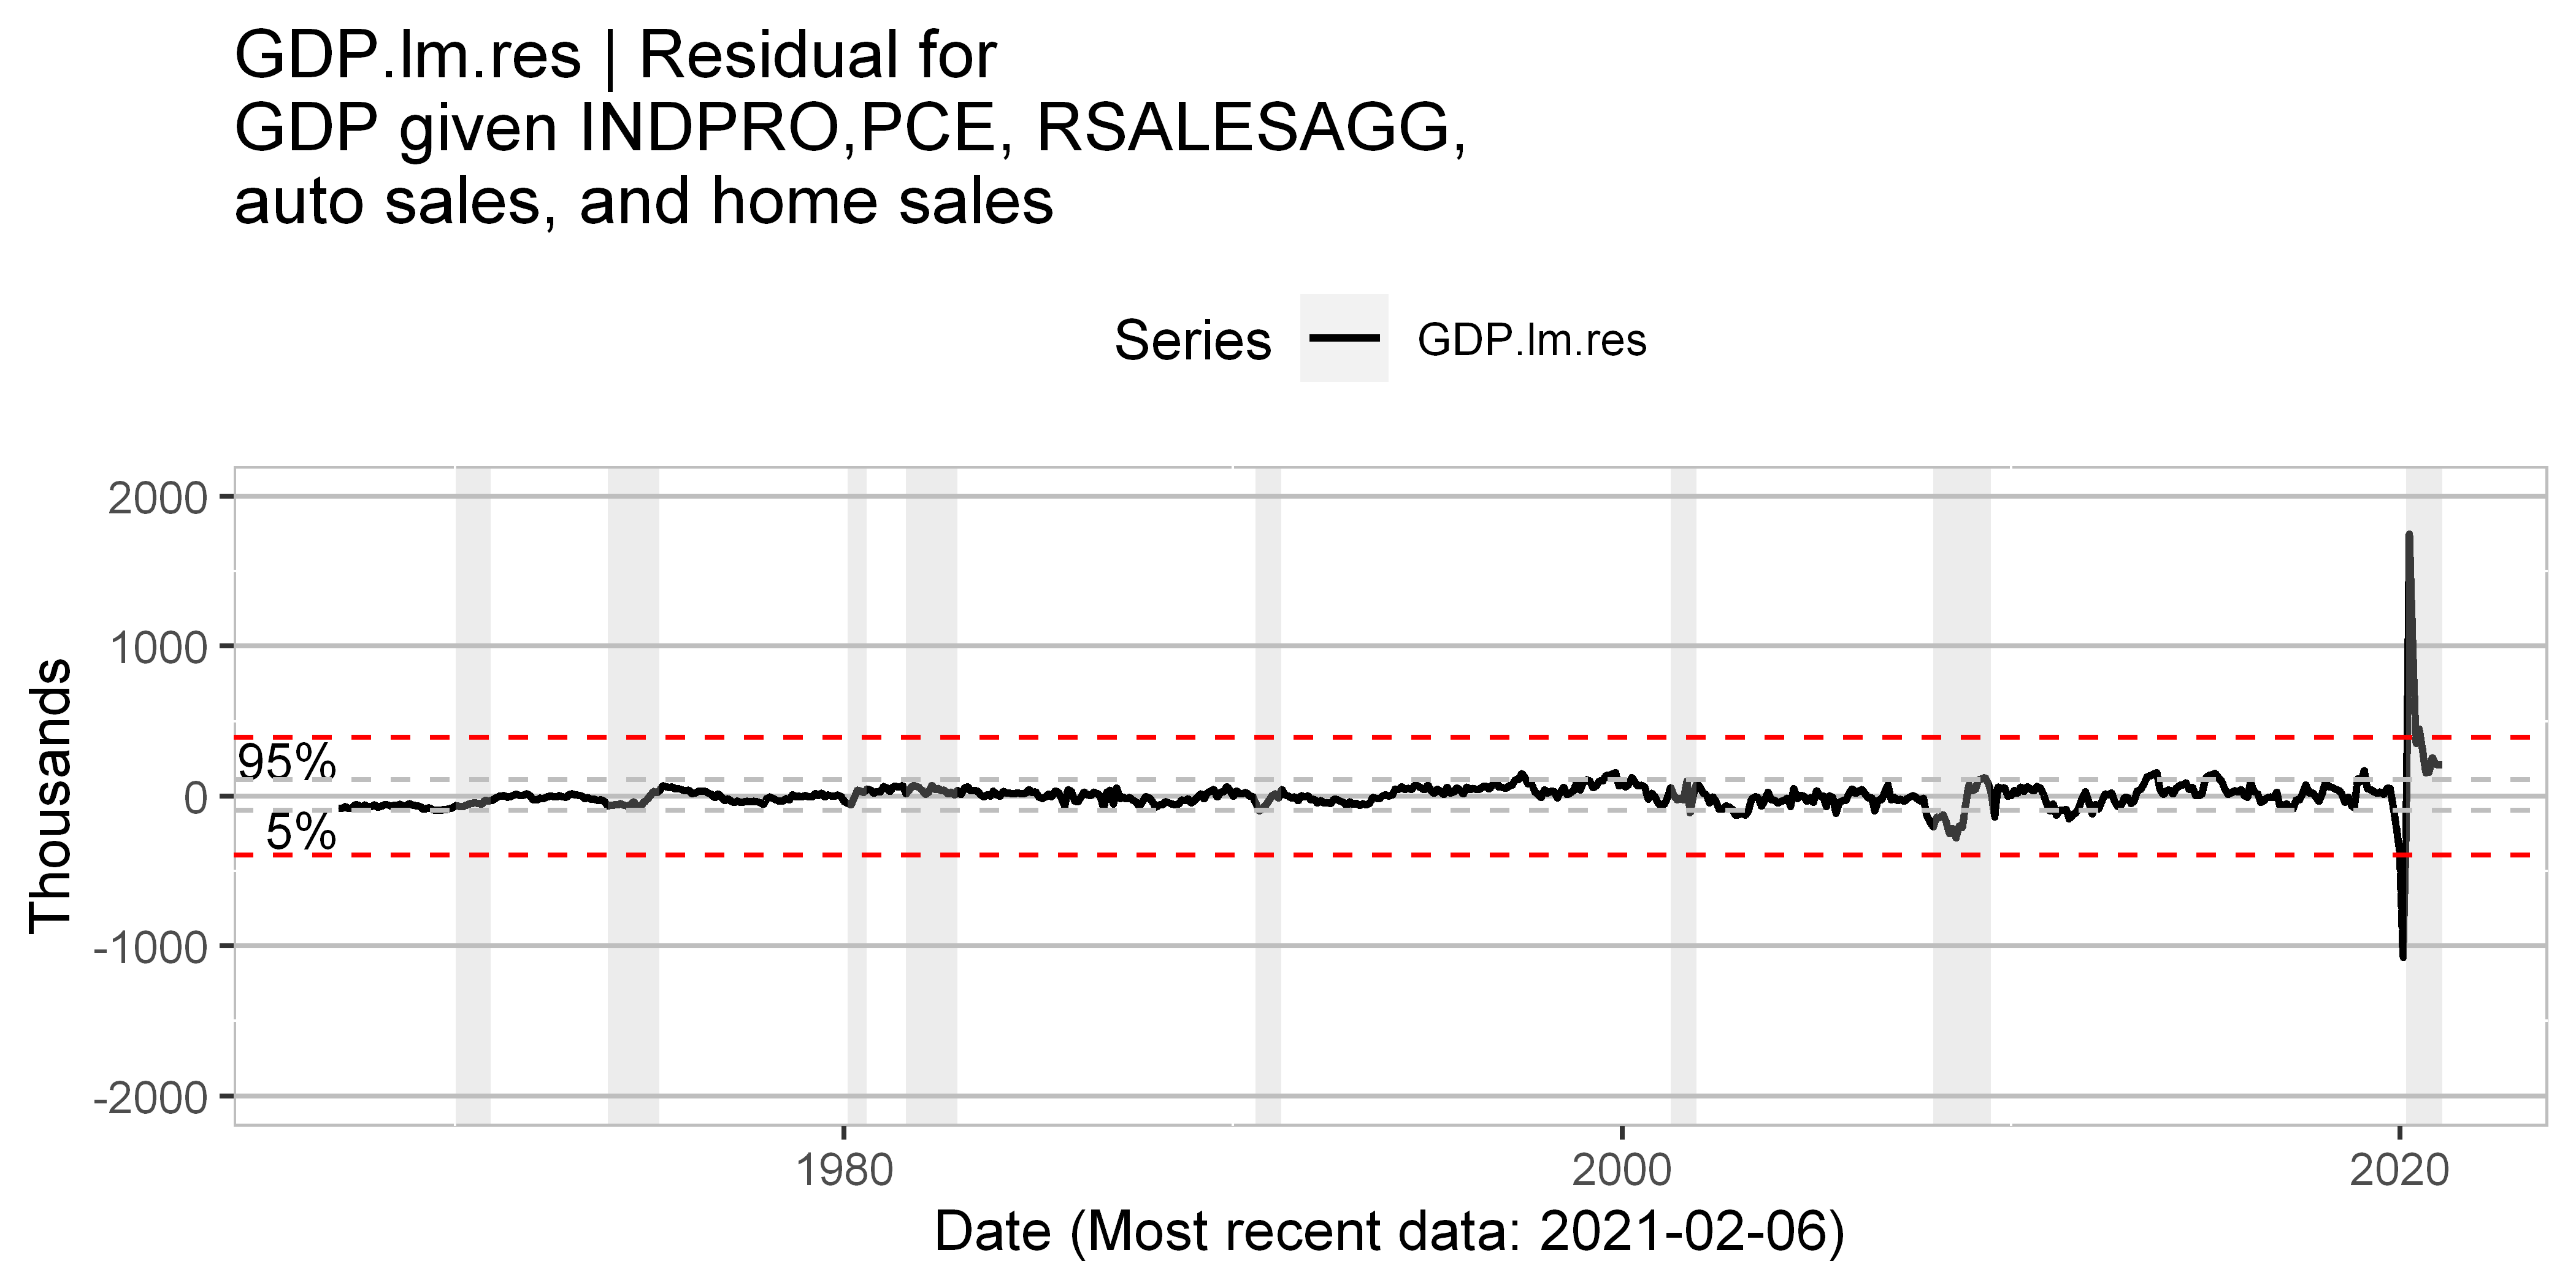

In [32]:
datay <- str.symbol.res
ylim <- c(-2000, 2000)
myPlot <- plotSingle(
  dfRecession,
  df.data,
  "date",
  datay,
  getPlotTitle(df.symbols, datay),
  "Date",
  getPlotYLabel(df.symbols, datay),
  c(as.Date("1jan1967", "%d%b%Y"), Sys.Date()),
  ylim,
  b.legend = TRUE,
  b.percentile = TRUE,
  b.long.legend = FALSE
)

myPlot <- myPlot + geom_hline(yintercept=(6*sd.fit.gdp.m), color = "red", linetype="dashed")
myPlot <- myPlot + geom_hline(yintercept=(-6*sd.fit.gdp.m), color = "red", linetype="dashed")

print(myPlot)

Plot the residual GDP to the PCR fit prediction. 

The residuals decrease quite a bit during the Covid numbers, at least as of Jun 2020. Probably indicates uncertainty in the numbers.

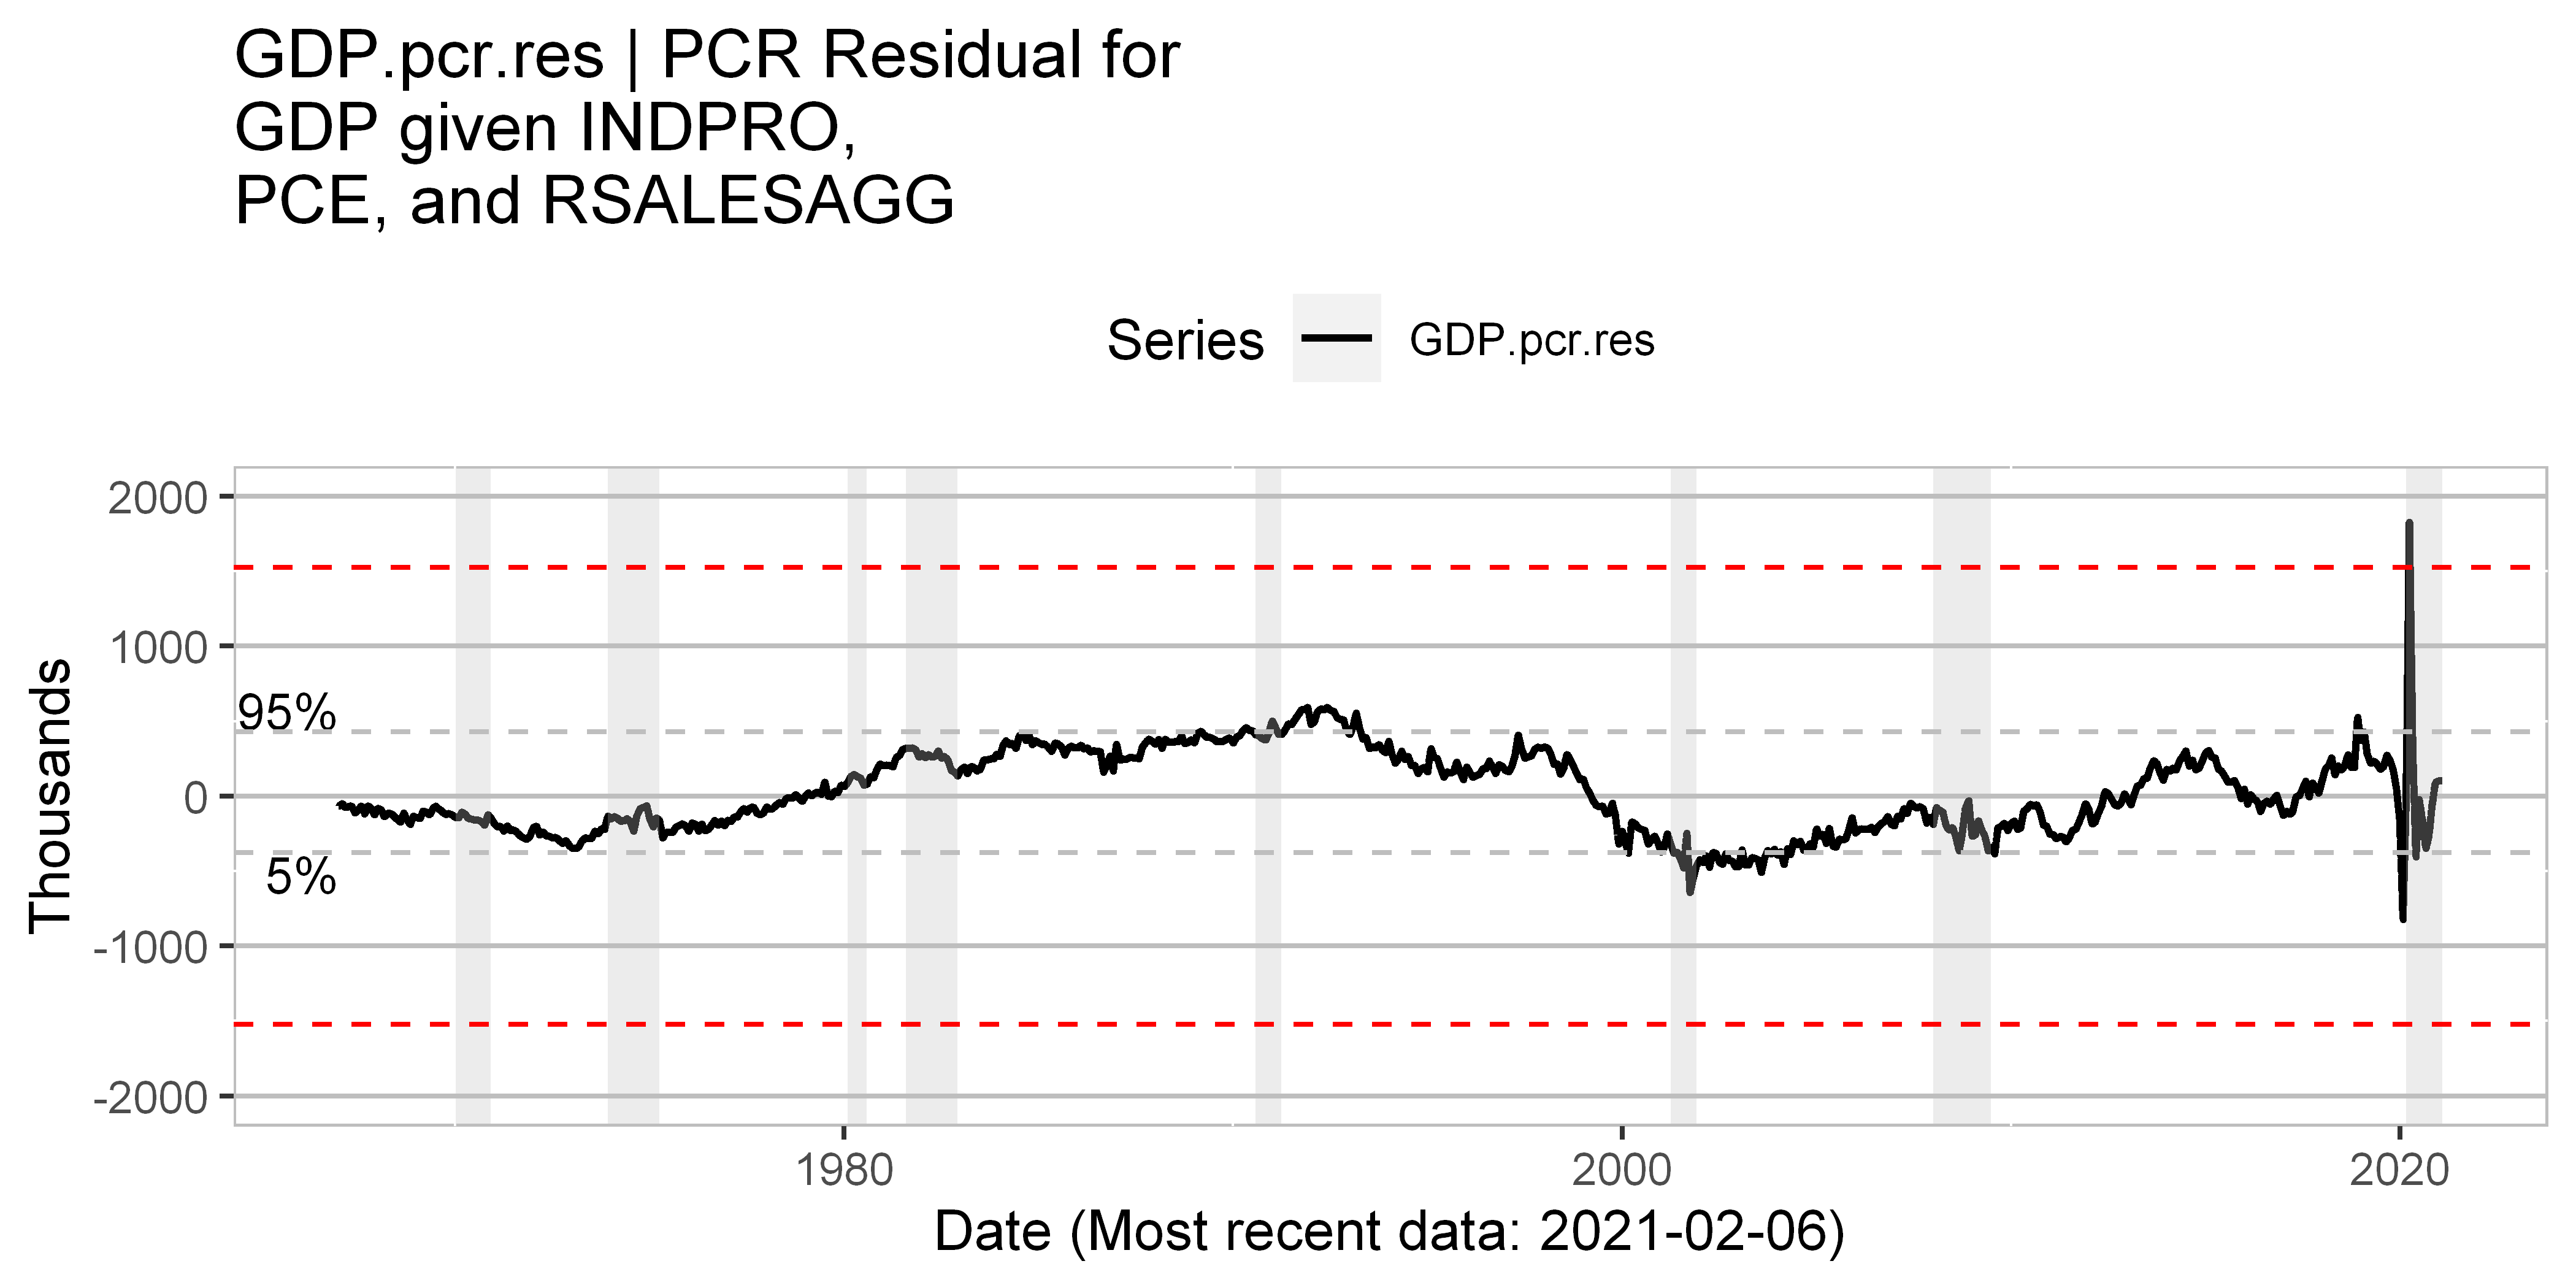

In [33]:
datay <- str.symbol.pcr.res
ylim <- c(-2000, 2000)
myPlot <- plotSingle(
  dfRecession,
  df.data,
  "date",
  datay,
  getPlotTitle(df.symbols, datay),
  "Date",
  getPlotYLabel(df.symbols, datay),
  c(as.Date("1jan1967", "%d%b%Y"), Sys.Date()),
  ylim,
  b.legend = TRUE,
  b.percentile = TRUE,
  b.long.legend = FALSE
)

myPlot <- myPlot + geom_hline(yintercept=(6*sd.fit.gdp.pcr), color = "red", linetype="dashed")
myPlot <- myPlot + geom_hline(yintercept=(-6*sd.fit.gdp.pcr), color = "red", linetype="dashed")

print(myPlot)


### Regression, Advanced Retail sales

See if we can get there with a simple regression model. Begin by taking a look at how these datapoints correlate with advanced retail sales

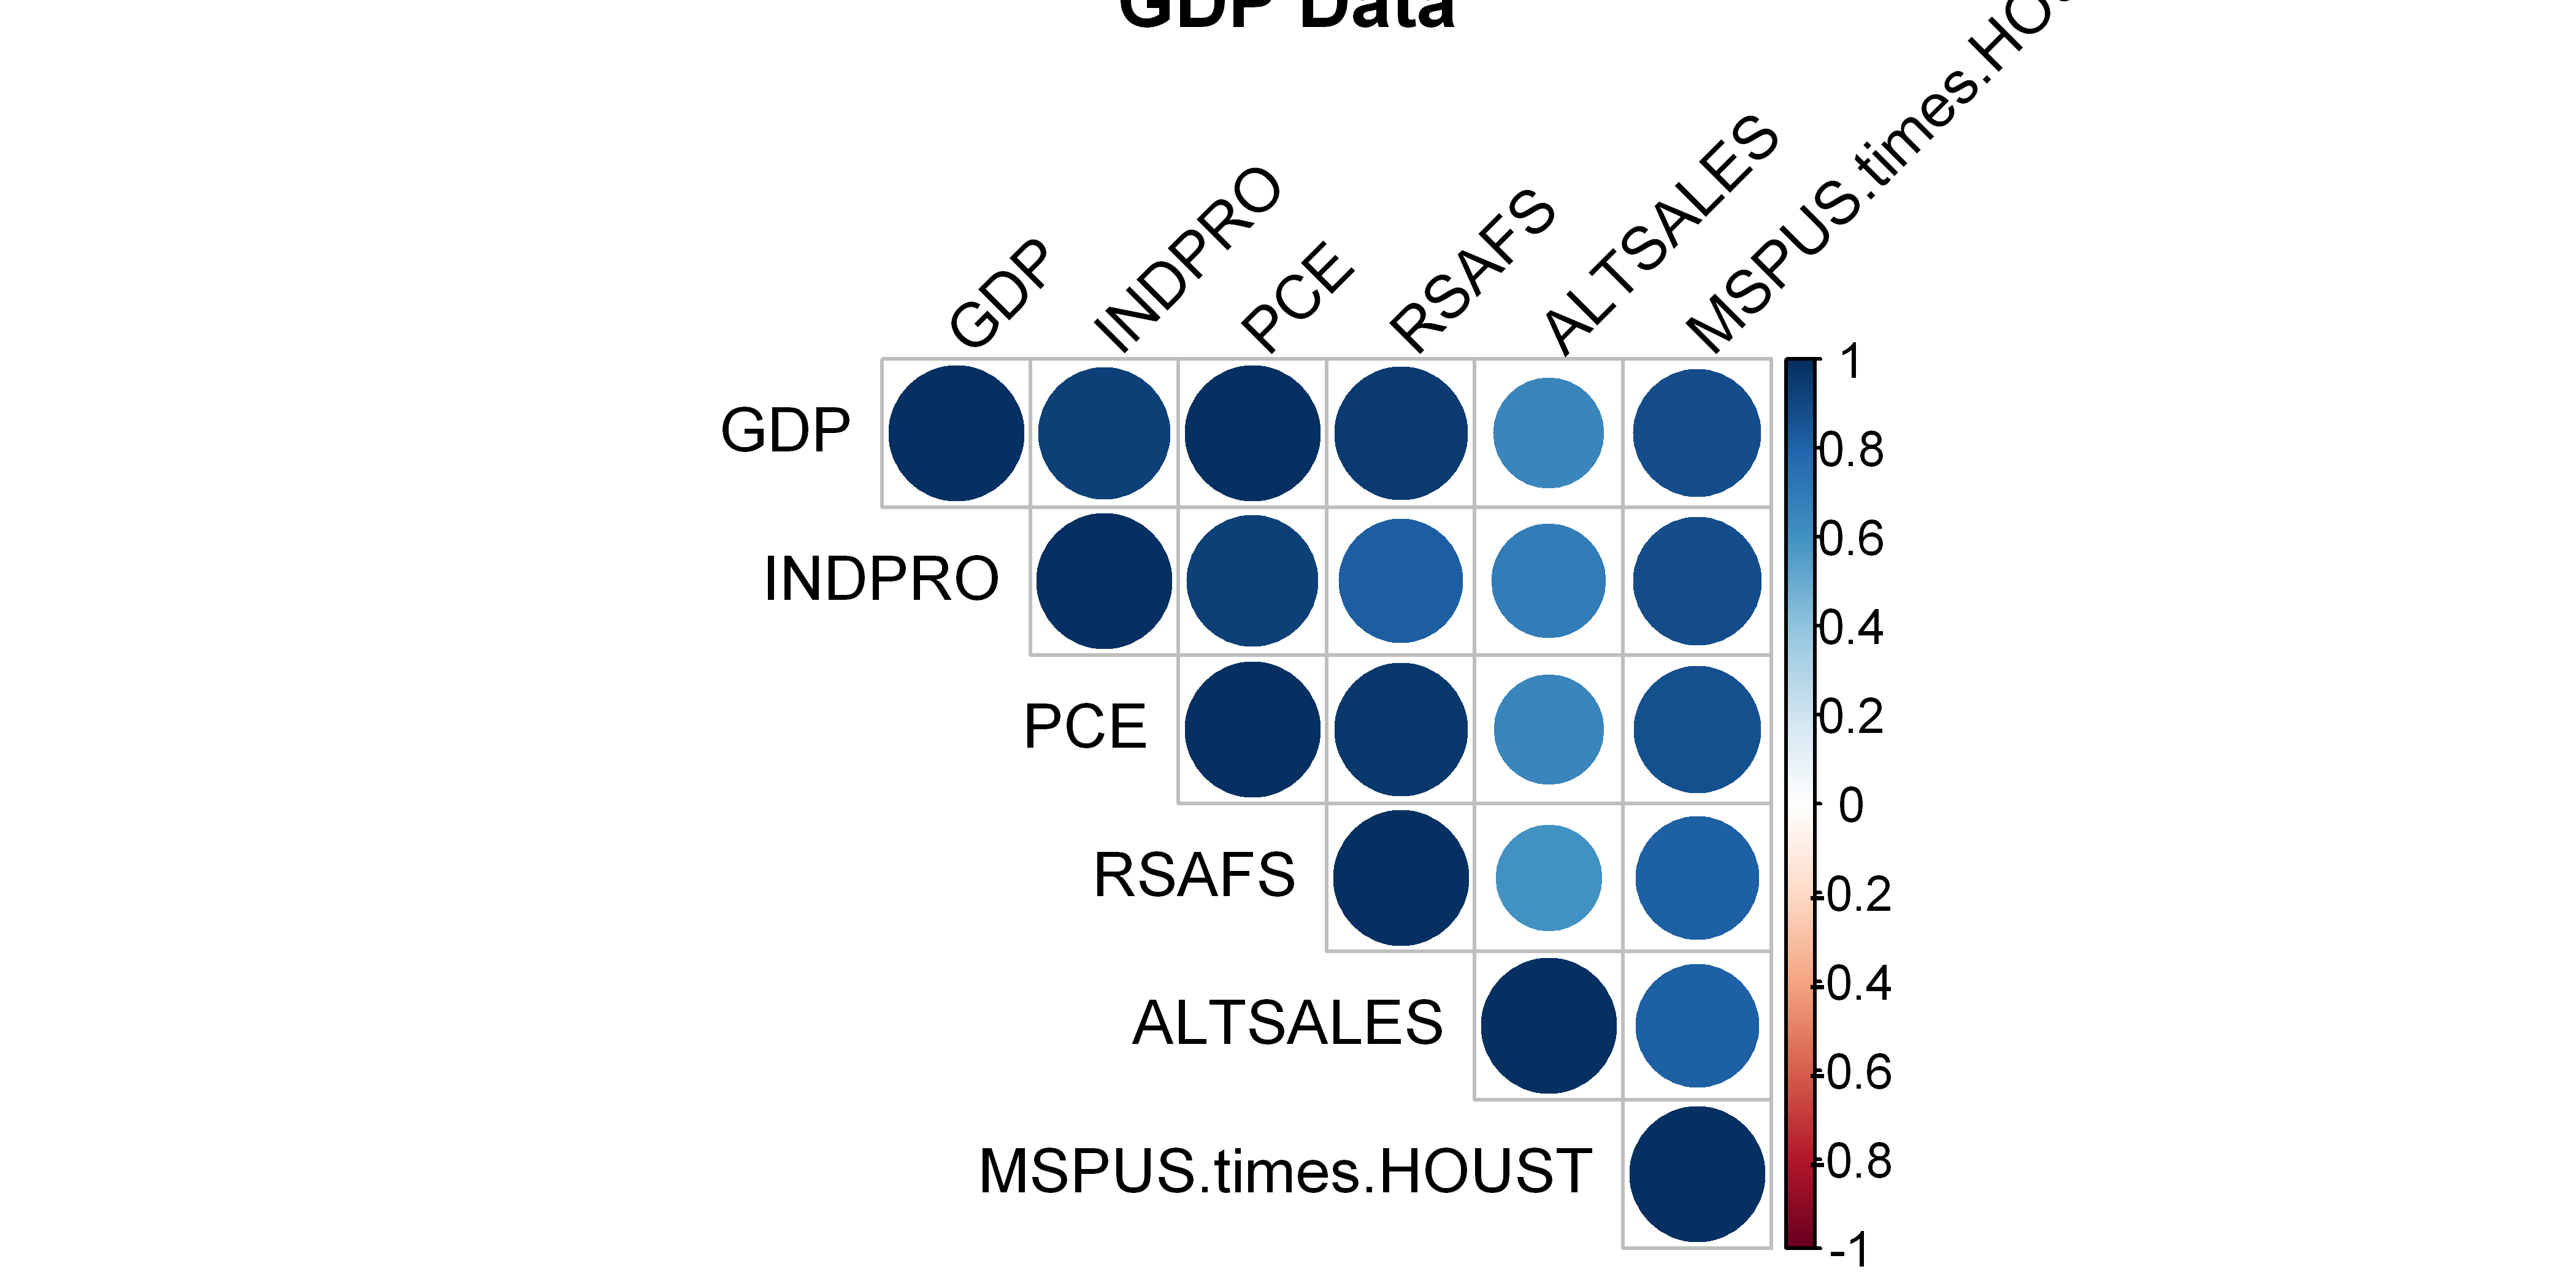

In [34]:
# Correlation for the entire data set
training.cor <-
  df.data[, c("GDP", "INDPRO", "PCE", "RSAFS", "ALTSALES", "MSPUS.times.HOUST")]

  rcorr.data <- rcorr(as.matrix(training.cor), type = "pearson")
  #print(rcorr.data)

  corrplot::corrplot(cor(training.cor), type="upper", order="original", 
           tl.col="black", tl.srt=45, title ="GDP Data")

In [35]:

df.gdp.model <-
  df.data[df.data$date >= dt.start.prediction &
            df.data$date <= dt.end.prediction,]

# I break the data into three sets: 50% for training, 25% for testing, and 25% for validation.
set.seed(123456)
in.train <- createDataPartition(y=df.gdp.model$GDP, p = 0.50, list=FALSE)
df.train <- df.gdp.model[in.train,]
df.data.rest <- df.gdp.model[-in.train,]
in.val <- createDataPartition(y = df.data.rest$GDP, p = 0.50, list = FALSE)
df.val <- df.data.rest[in.val,]
df.test <- df.data.rest[-in.val,]
rm(df.data.rest)

# Perform the linear fit
list.fit.reg.adv <- train(
  GDP ~ INDPRO + PCE + RSAFS + ALTSALES + MSPUS.times.HOUST,
  data = df.train,
  method = "lm",
  preProcess = c('center', 'scale')
)


In [36]:
# Add linear prediction to the dataframe
str.symbol <- "GDP.lm.adv"
df.data[str.symbol] <-
  predict(list.fit.reg.adv, newdata = df.data)

# Add the linear model prediction to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol,
      string.source = "Predict",
      string.description = "Linear Model Prediction\nGDP given INDPRO,\nPCE, RSAFS, auto sales,\nand housing",
      string.label.y = getPlotYLabel(df.symbols, "POPTHM")[1],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

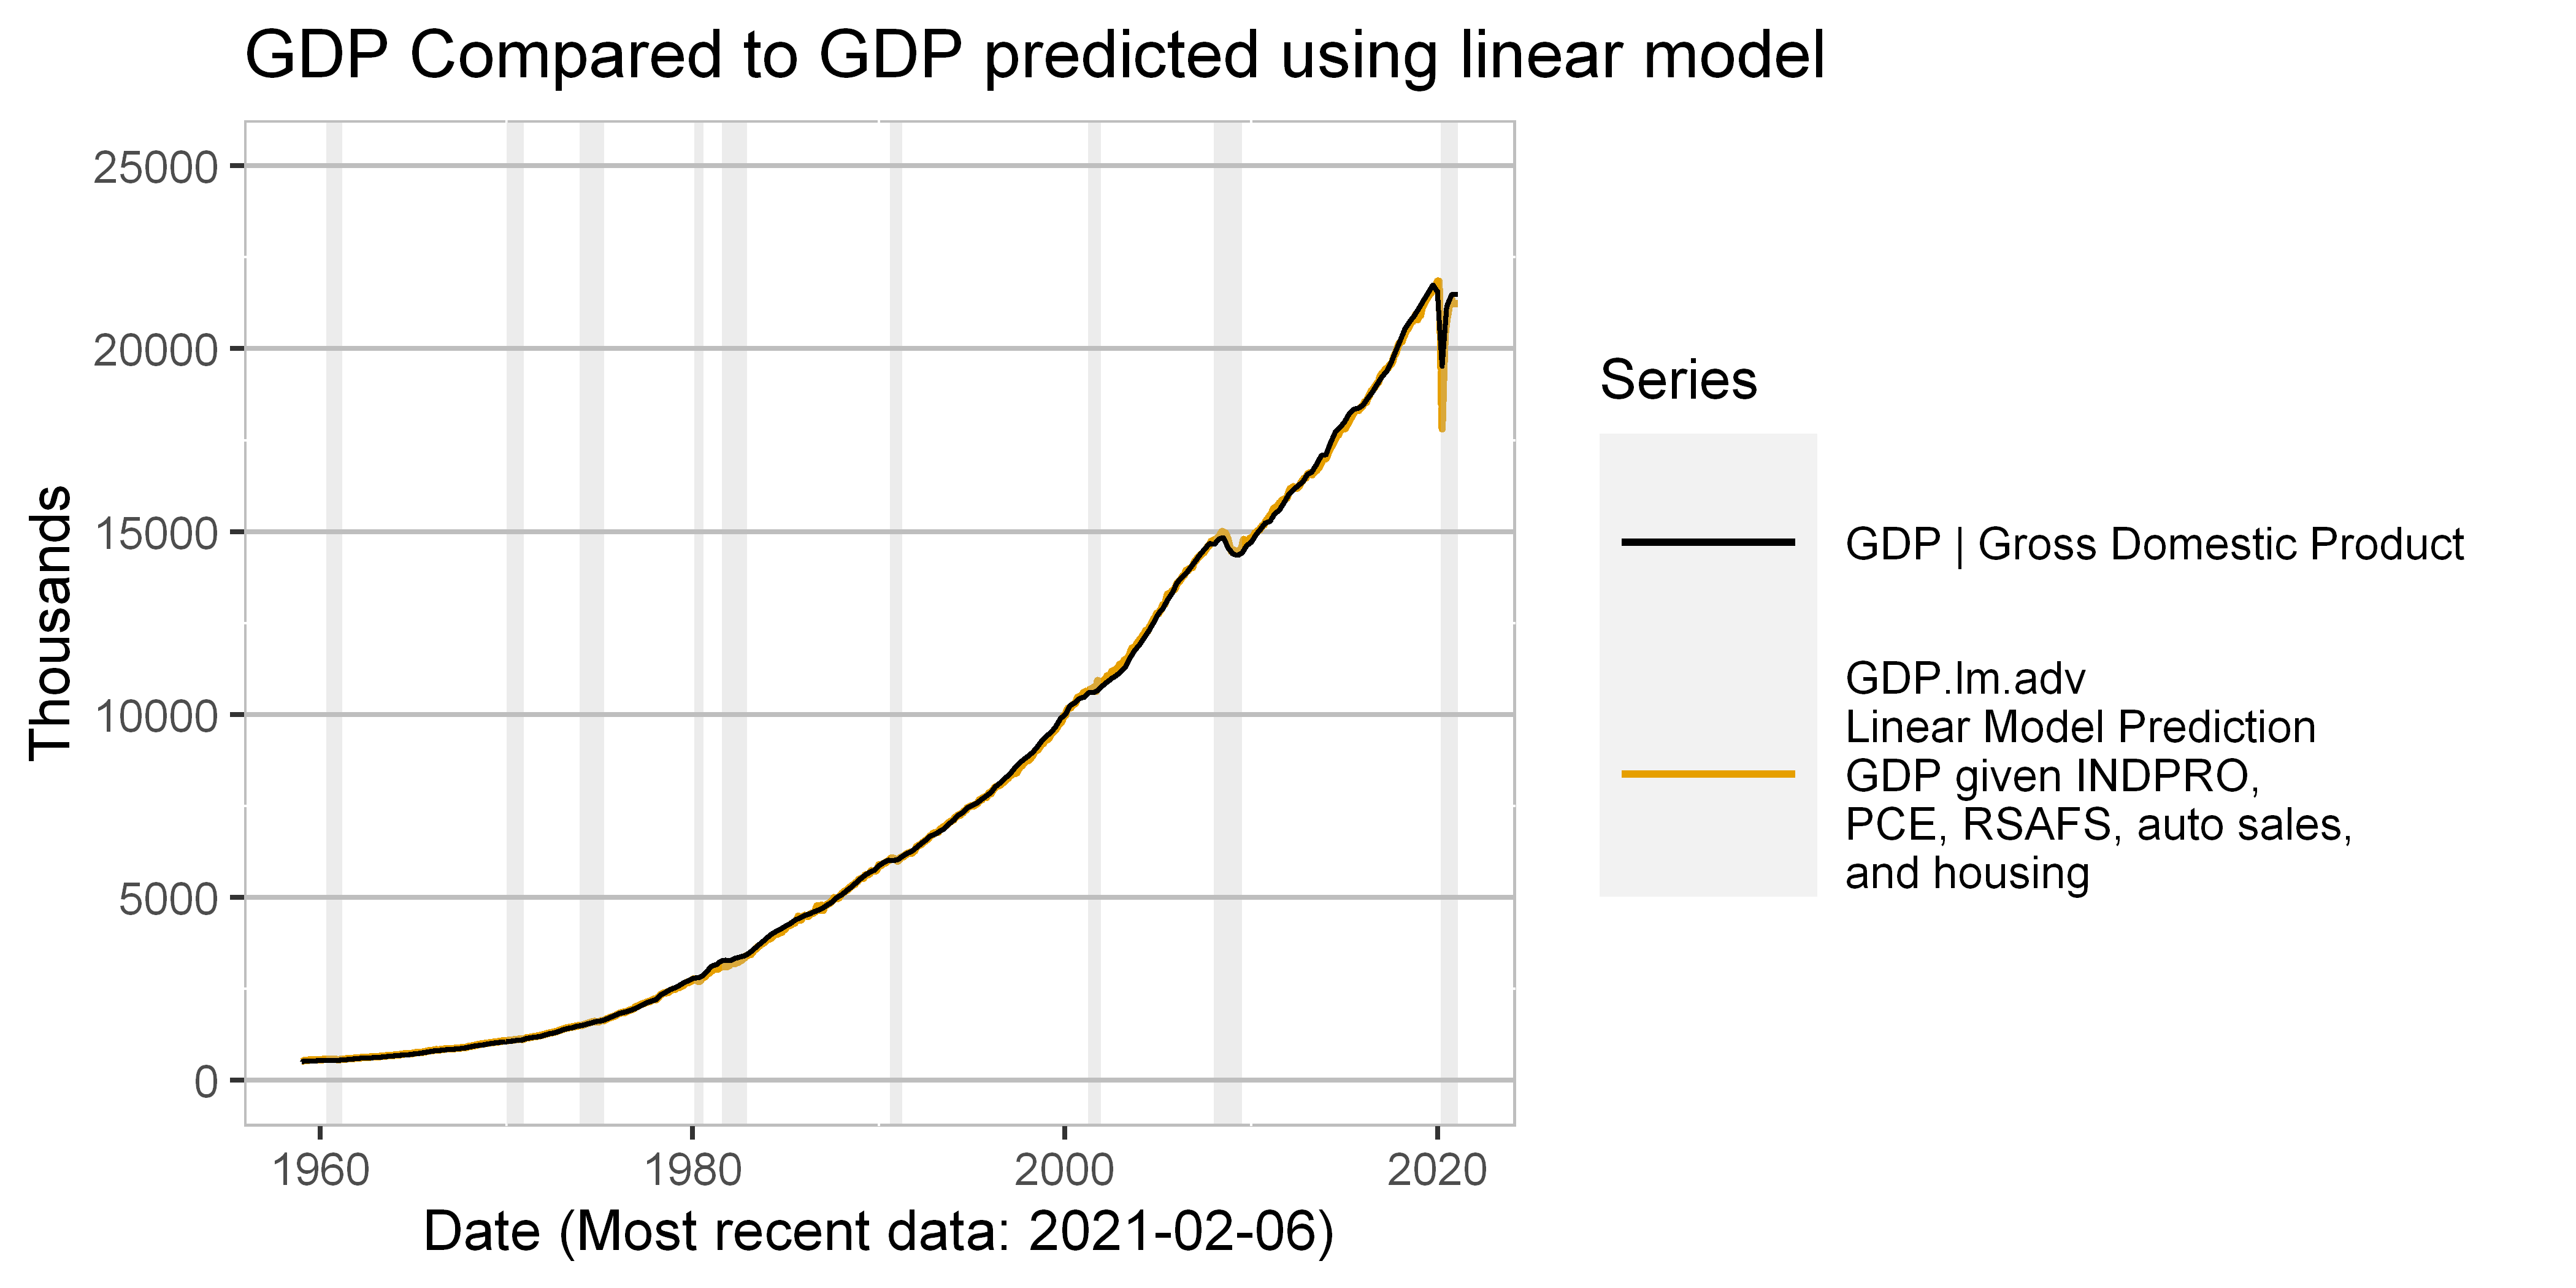

In [37]:

datay <- "GDP.lm.adv"
datay.aux <- "GDP"
ylim <- c(0, 25000)
dt.end <- Sys.Date()
myPlot <- 
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "GDP Compared to GDP predicted using linear model",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.start.prediction, dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux))
  ),
  na.rm = TRUE
)

print(myPlot)

Looking at some more recent data points

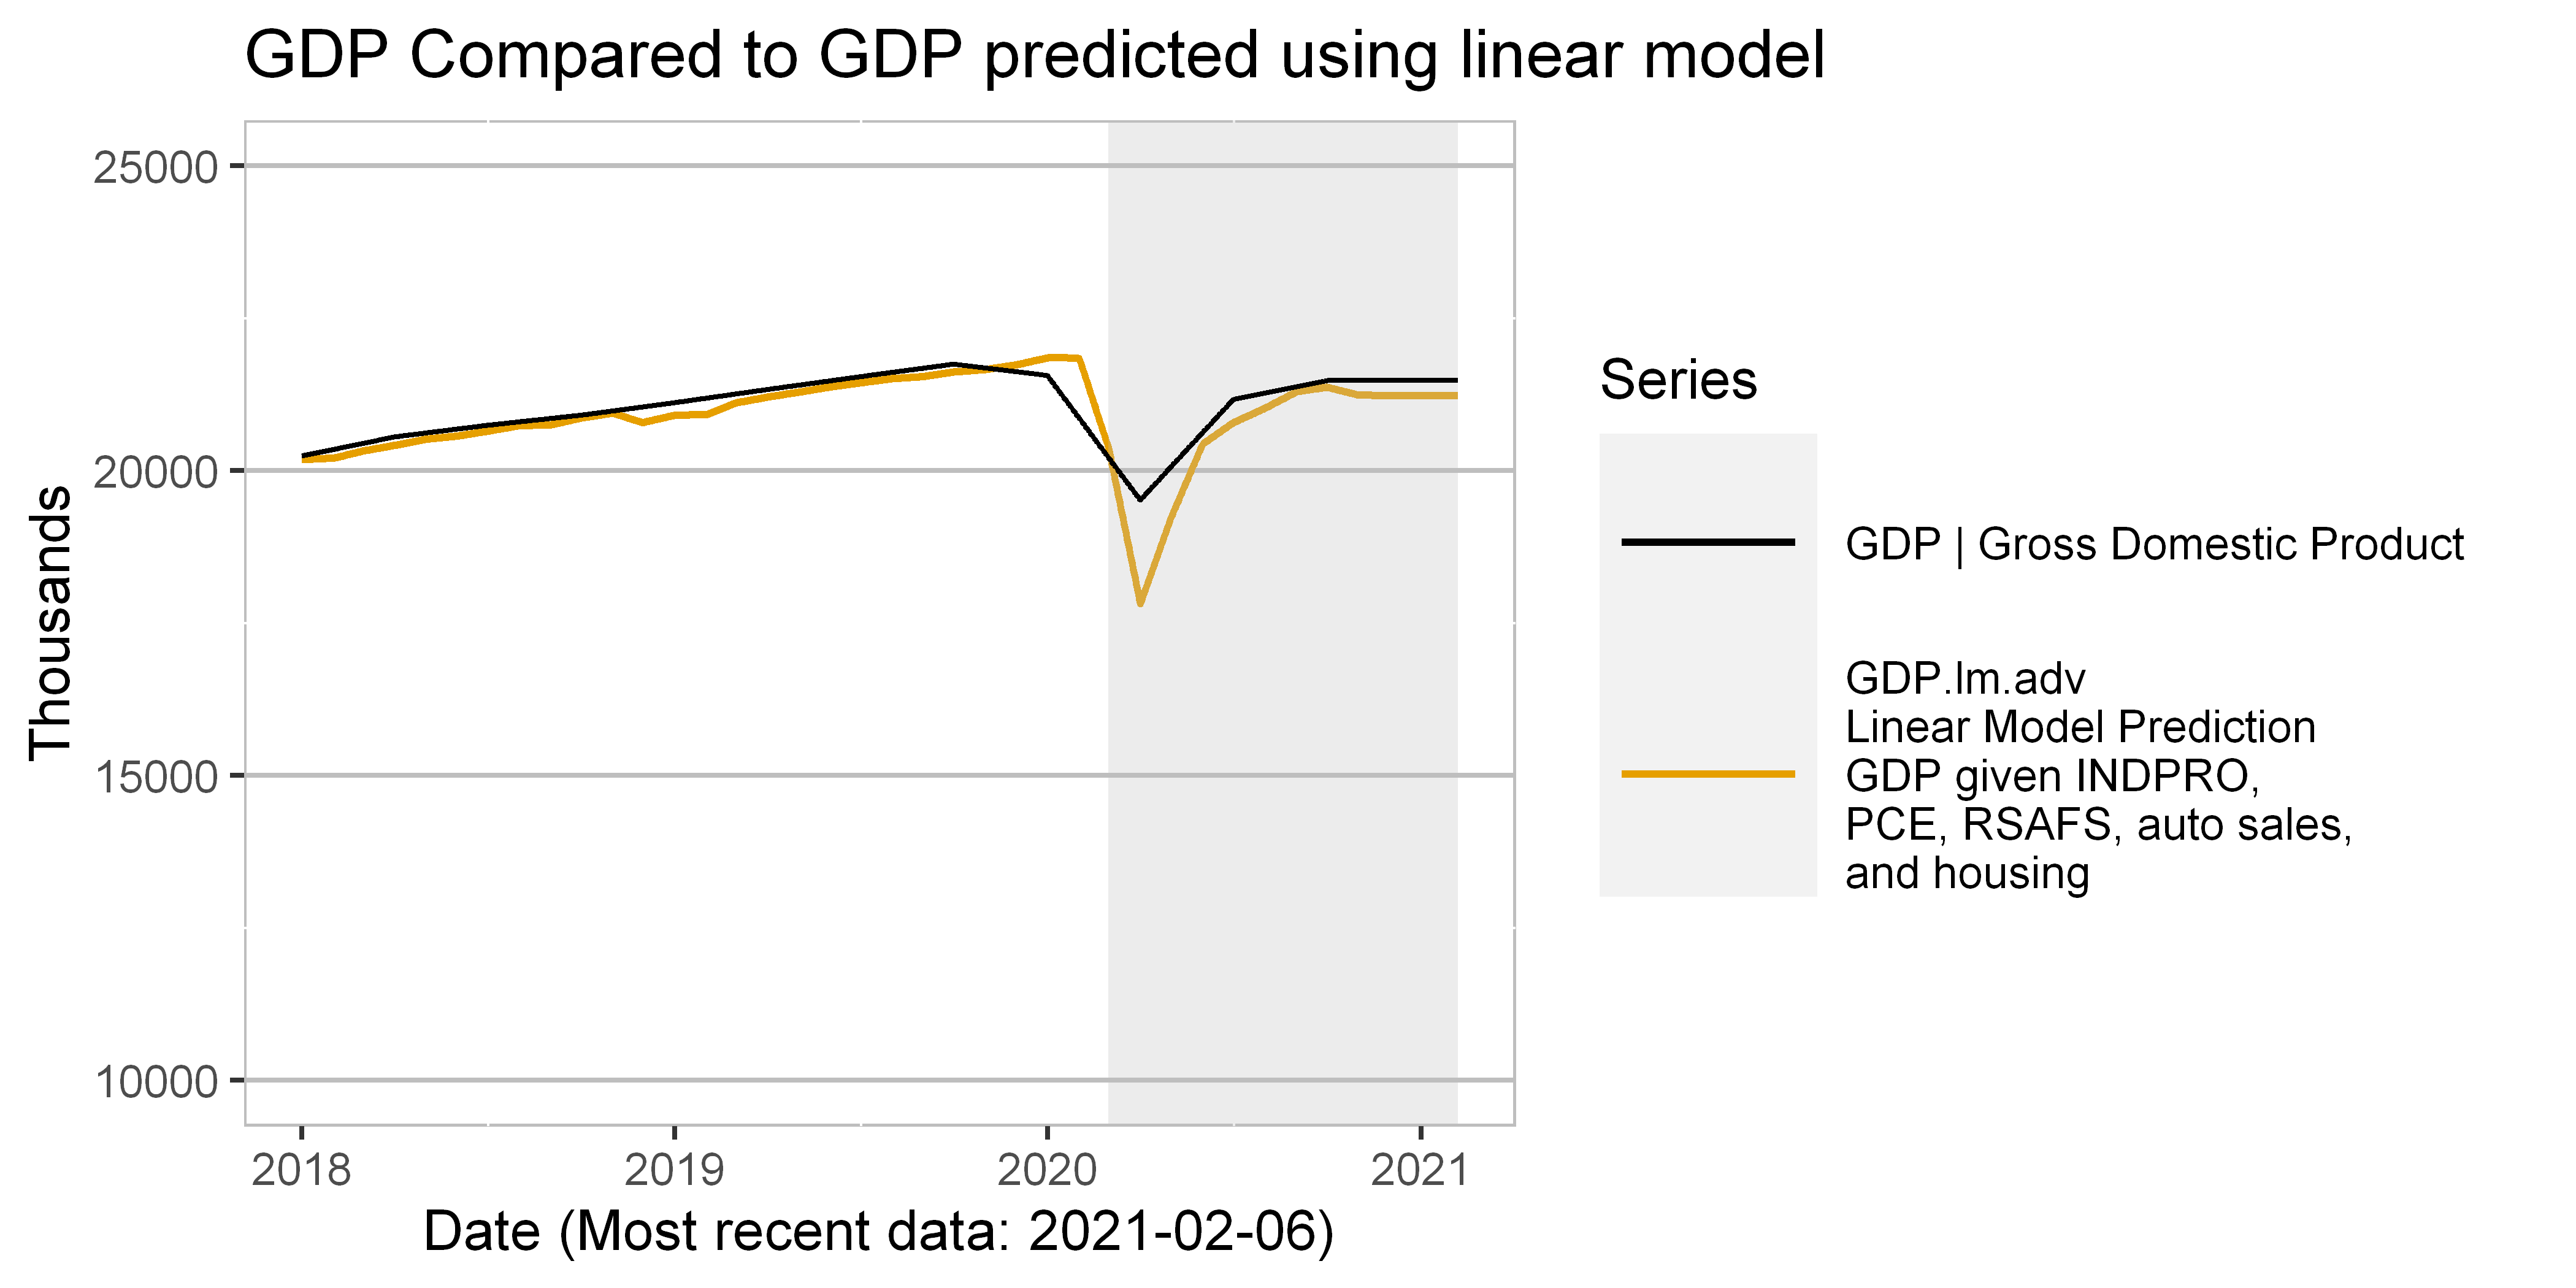

In [38]:
datay <- "GDP.lm.adv"
datay.aux <- "GDP"
ylim <- c(10000, 25000)
dt.end <- Sys.Date()
dt.start <- as.Date("2018-01-01")
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "GDP Compared to GDP predicted using linear model",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.start, dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux))
  ),
  na.rm = TRUE
)

print(myPlot)

Look at how the GDP linear fit performed on the test data partition

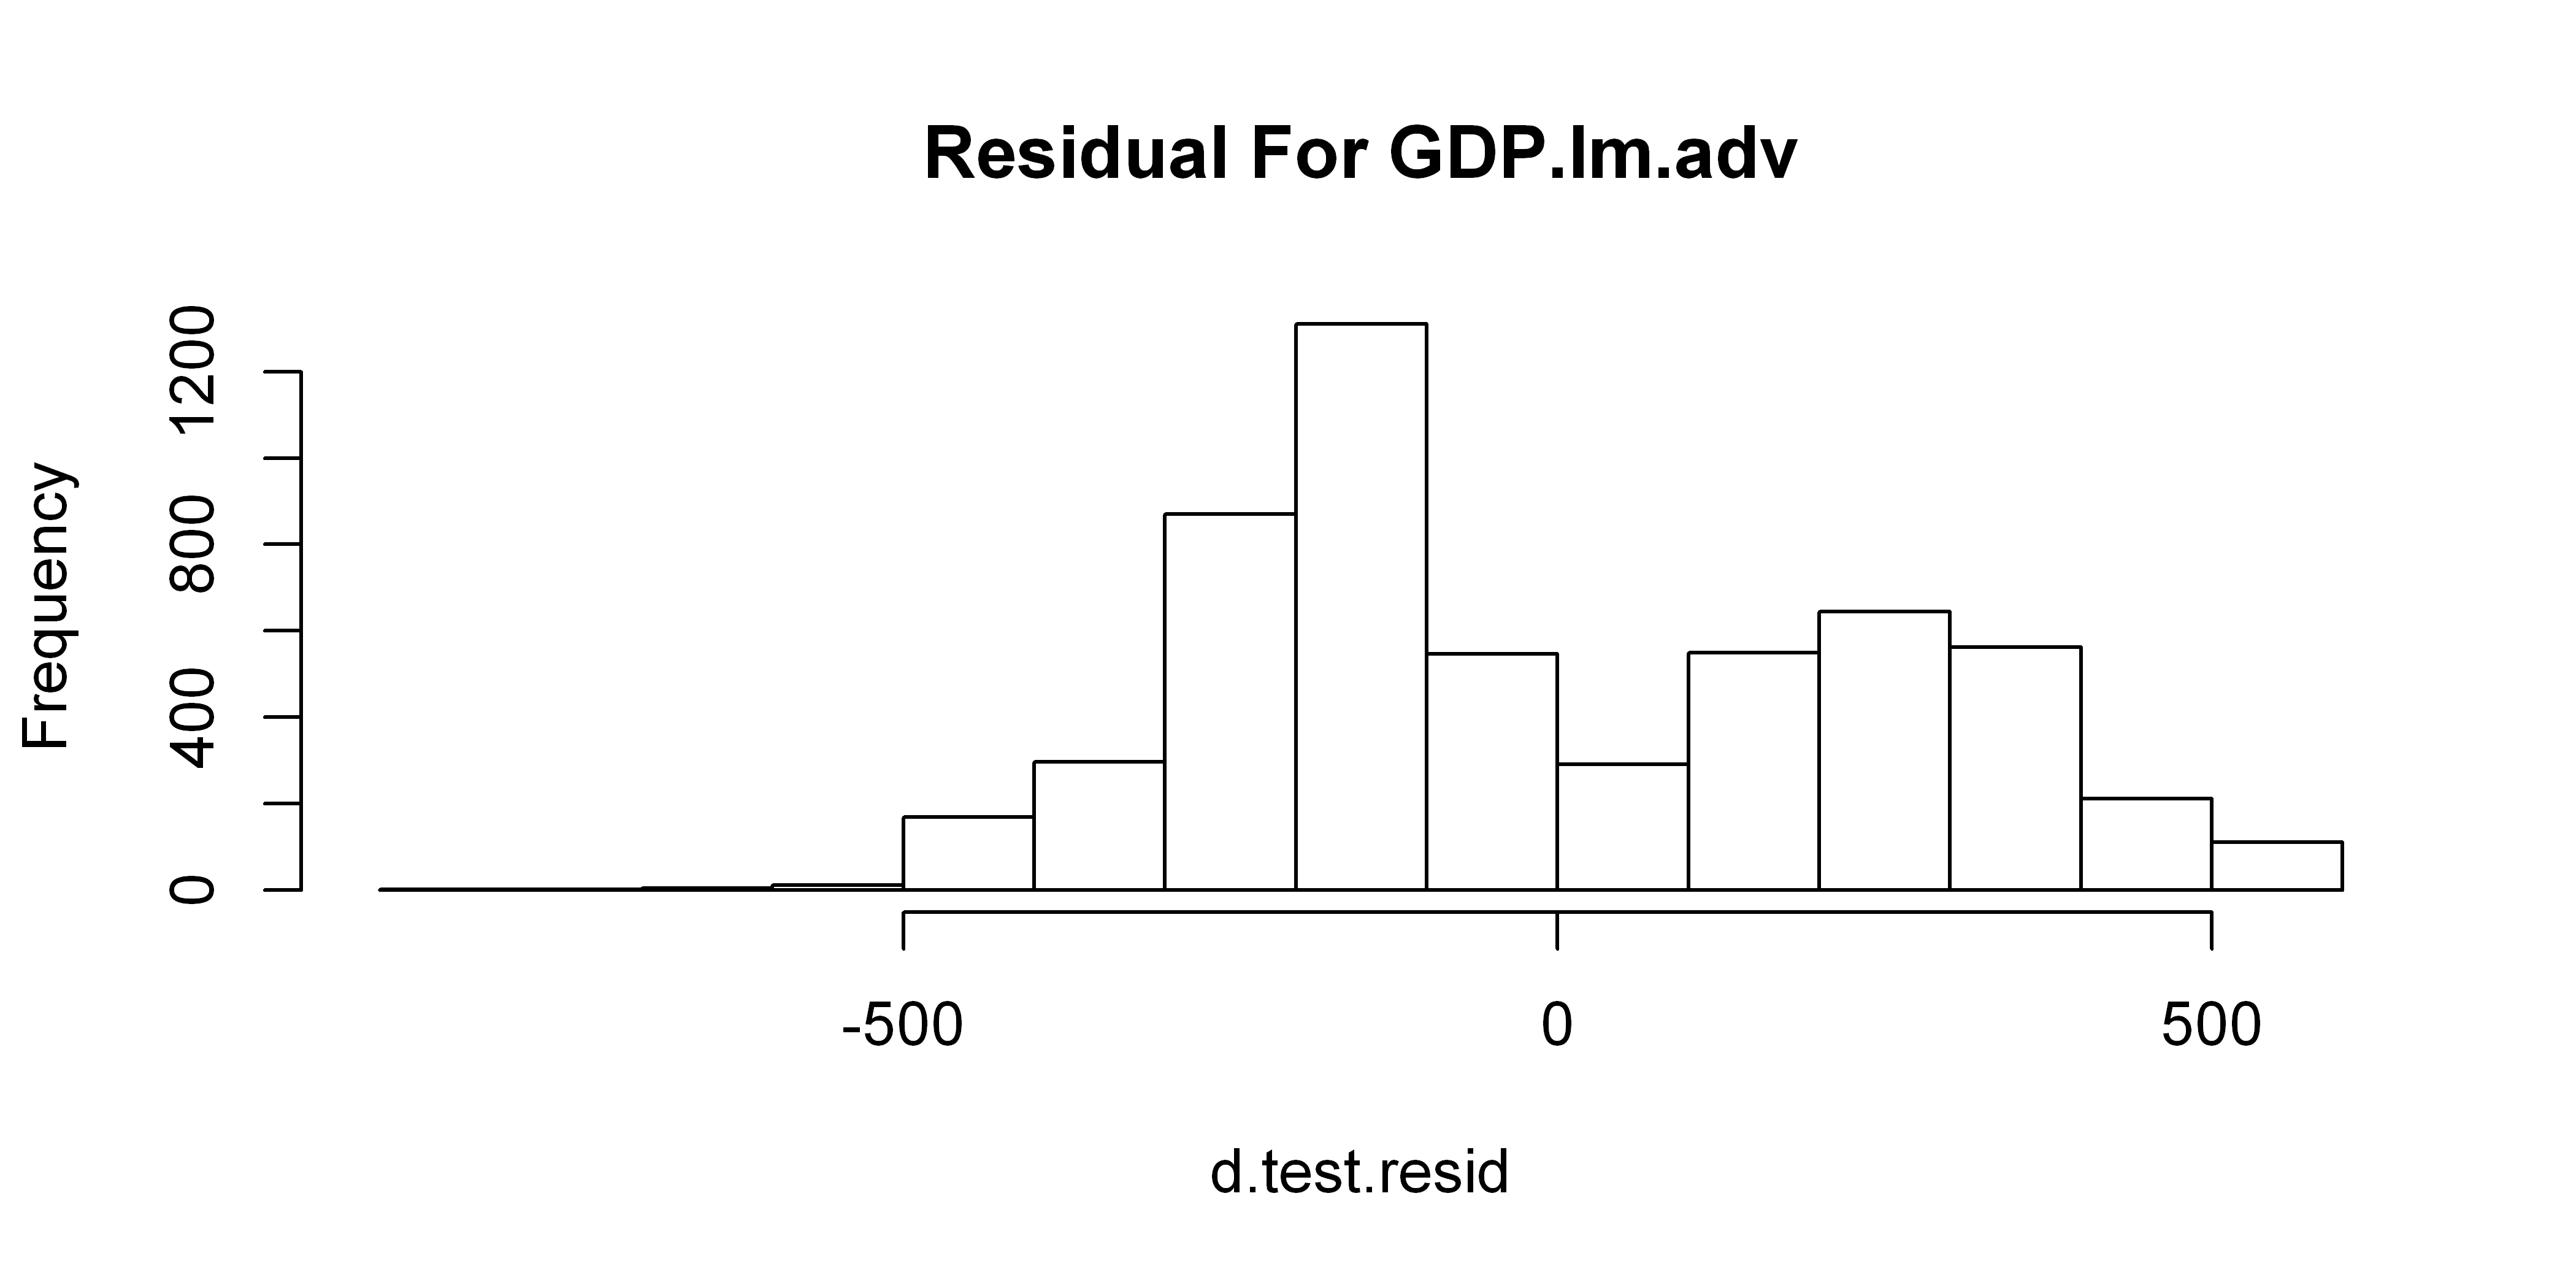

In [39]:
d.test.resid.adv = (df.test$GDP - predict(list.fit.reg.adv, newdata = df.test))
hist(d.test.resid, main=paste("Residual For", str.symbol, sep=" "))
sd.fit.gdp.lm.adv = sd(d.test.resid)


In [40]:
list.fit.reg.adv$finalModel


Call:
lm(formula = .outcome ~ ., data = dat)

Coefficients:
      (Intercept)             INDPRO                PCE              RSAFS  
          7402.49             116.35            6449.36            -302.21  
         ALTSALES  MSPUS.times.HOUST  
            23.23              28.12  


Document the residual as well

In [41]:
str.symbol.res <- "GDP.lm.adv.res"
df.data[str.symbol.res] <- df.data$GDP - df.data[str.symbol]

# Add the GDP linear model prediction residual to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol.res,
      string.source = "Predict Resid.",
      string.description = "Residual for \nGDP given INDPRO,\nPCE, and RSALESAGG",
      string.label.y = df.symbols[df.symbols$string.symbol==str.symbol,"string.label.y"],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )


Plot the residual  GDP to the linear fit prediction. 

The residuals decrease quite a bit during the Covid numbers, at least as of Jun 2020. Probably indicates uncertainty in the numbers.

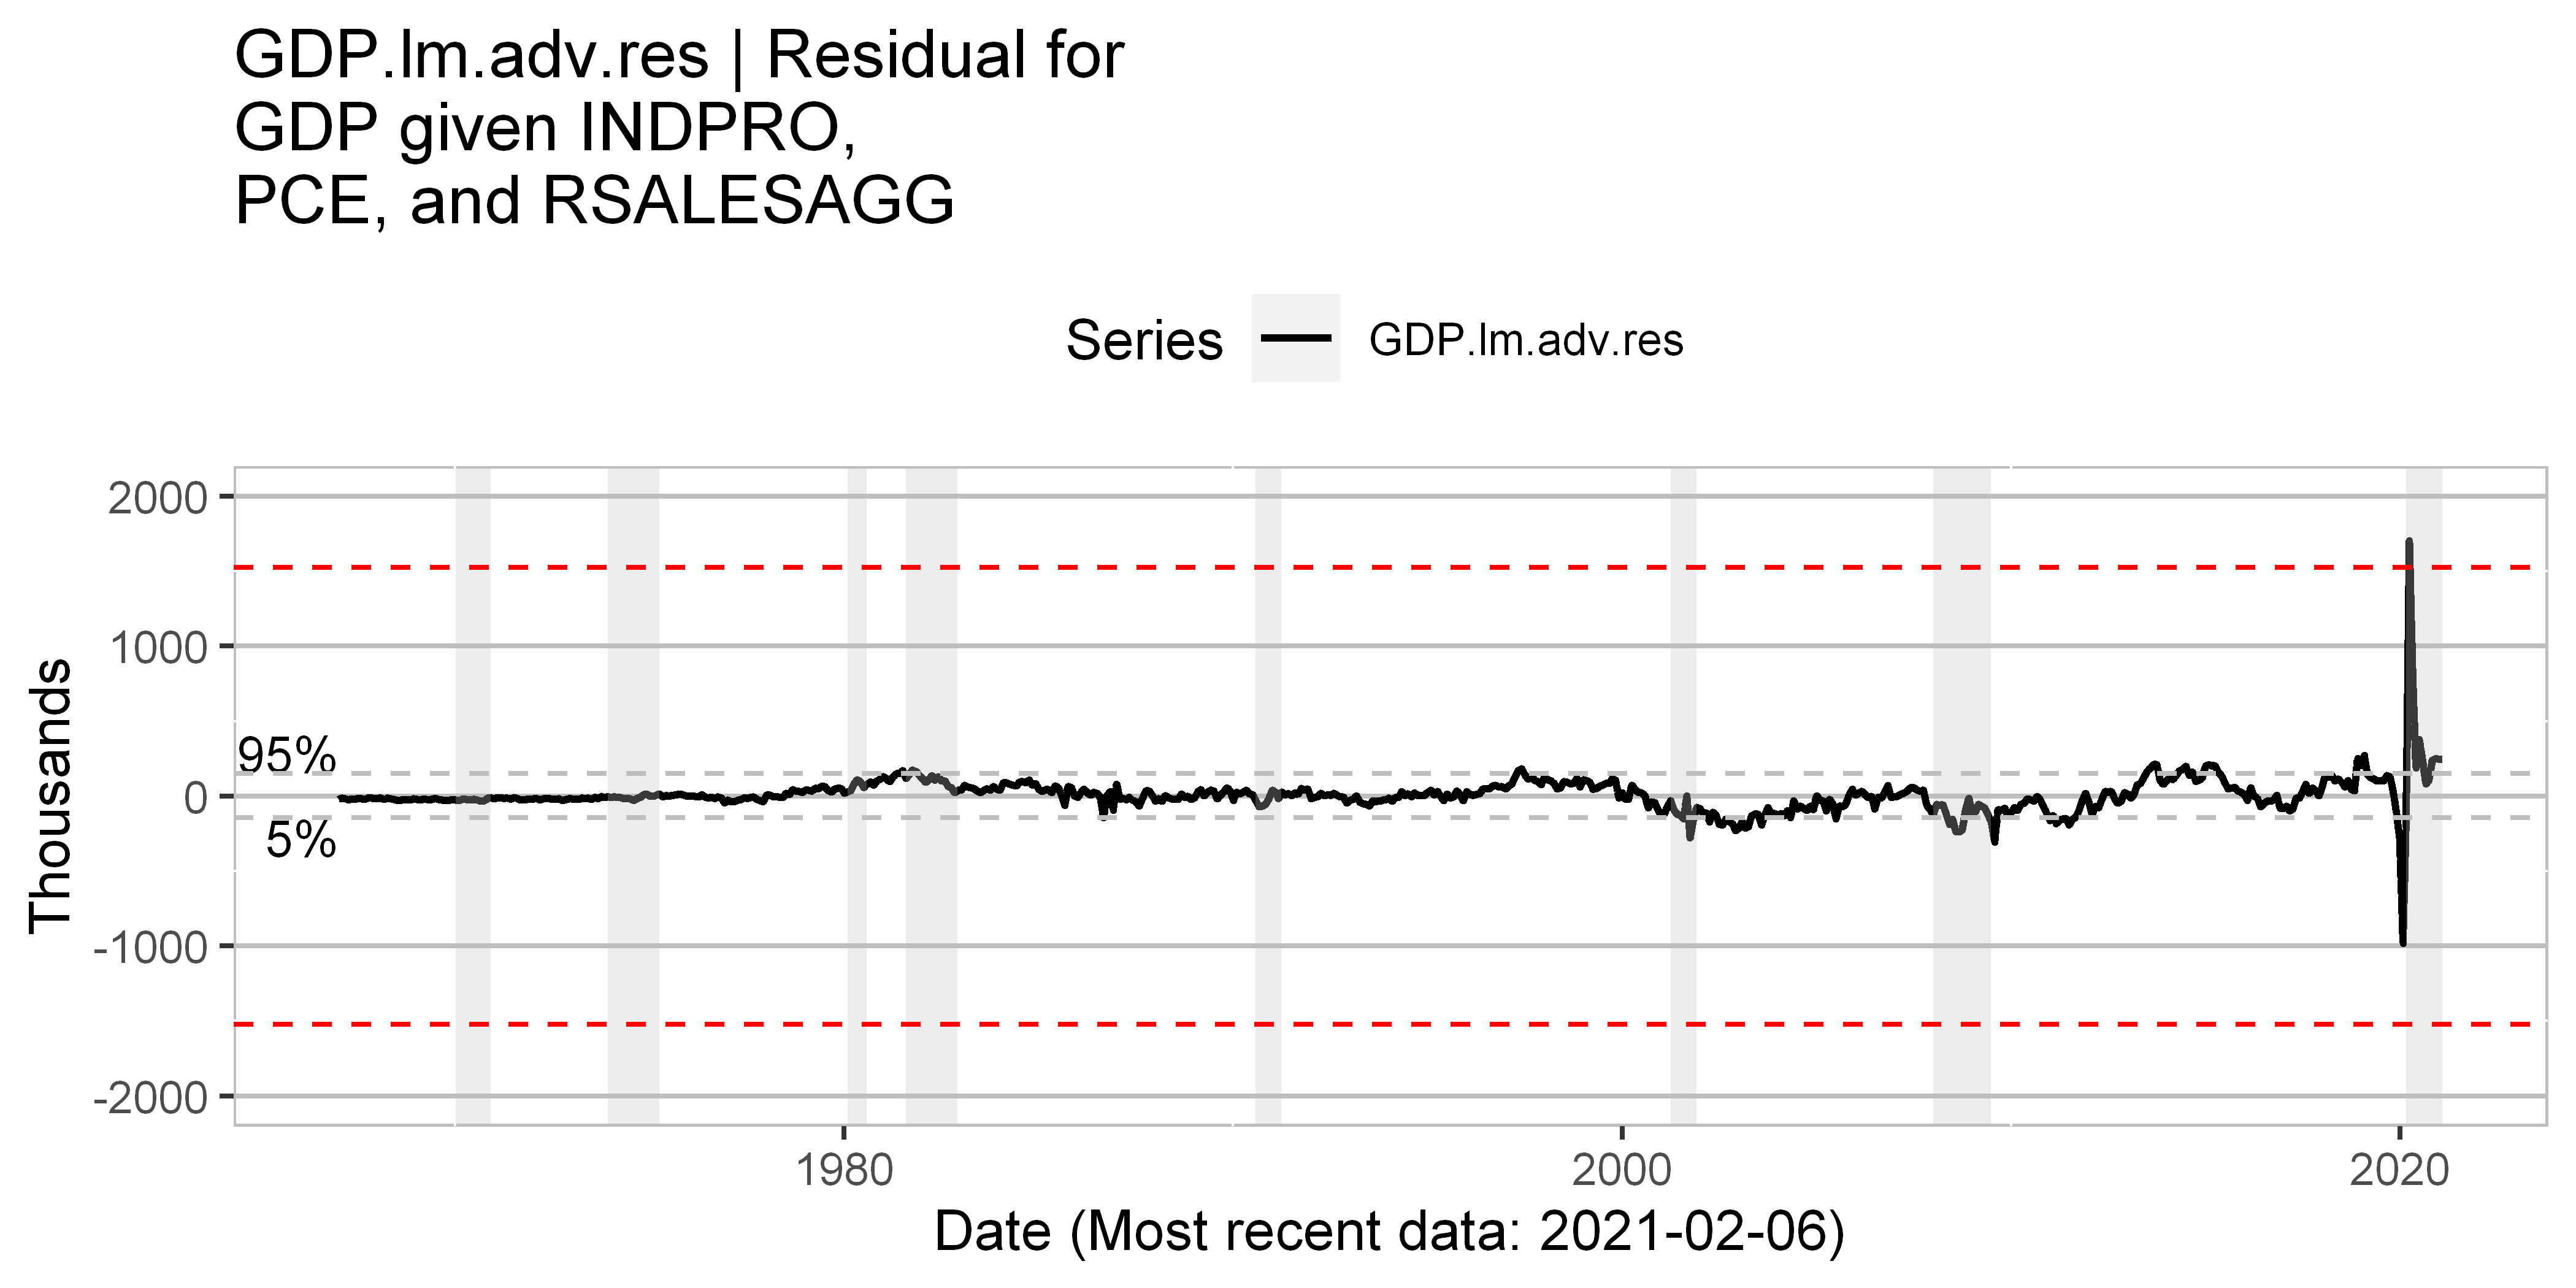

In [42]:
datay <- str.symbol.res
ylim <- c(-2000, 2000)
myPlot <- plotSingle(
  dfRecession,
  df.data,
  "date",
  datay,
  getPlotTitle(df.symbols, datay),
  "Date",
  getPlotYLabel(df.symbols, datay),
  c(as.Date("1jan1967", "%d%b%Y"), Sys.Date()),
  ylim,
  b.legend = TRUE,
  b.percentile = TRUE,
  b.long.legend = FALSE
)

myPlot <- myPlot + geom_hline(yintercept=(6*sd.fit.gdp.lm.adv), color = "red", linetype="dashed")
myPlot <- myPlot + geom_hline(yintercept=(-6*sd.fit.gdp.lm.adv), color = "red", linetype="dashed")

print(myPlot)
